# Maping the wave of spread of covid-19

In [64]:
import outbreak
import pandas as pd
import numpy as np
import geopandas as gpd
import copy
import matplotlib.pyplot as plt
import os
os.environ['MAPBOX_API_KEY'] = 'pk.eyJ1IjoiZmNjb2VsaG8iLCJhIjoiY2s4c293dzc3MGJodzNmcGEweTgxdGpudyJ9.UmSRs3e4EqTOte6jYWoaxg'
import pydeck
import ujson

## Loading the data

In [65]:
F = outbreak.read_flow_matrix('../dados/flowmatrix_full_mun.csv.gz', header=0) 
nodes = outbreak.read_nodes('../dados/nodesUF.csv.gz')
# nodes['incidence'] = nodes.I/nodes.tgtpop
mapa = gpd.read_file('../mapas/muni_br.gpkg')
# Fetching cases from Brasil.io
cases = pd.read_csv('https://brasil.io/dataset/covid19/caso?format=csv')
nodesc = pd.merge(nodes,cases[(cases.is_last)], left_on='tgt', right_on='city_ibge_code', how='left')
nodesc = nodesc[['tgt','tgtname','tgt_UFCOD','tgtpop','confirmed']]
nodesc.fillna(0, inplace=True)
cases

date state               city place_type  confirmed  deaths  \
0      2020-04-15    AC         Acrelândia       city         11       0   
1      2020-04-15    AC             Bujari       city          1       0   
2      2020-04-15    AC    Cruzeiro do Sul       city          2       0   
3      2020-04-15    AC  Plácido de Castro       city         10       1   
4      2020-04-15    AC         Porto Acre       city          1       0   
...           ...   ...                ...        ...        ...     ...   
15919  2020-02-27    SP                NaN      state          1       0   
15920  2020-02-26    SP          São Paulo       city          1       0   
15921  2020-02-26    SP                NaN      state          1       0   
15922  2020-02-25    SP          São Paulo       city          1       0   
15923  2020-02-25    SP                NaN      state          1       0   

       is_last  estimated_population_2019  city_ibge_code  \
0         True                    15256.0       1200013.0   
1         True                    10266.0       1200138.0   
2         True                    88376.0       1200203.0   
3         True                    19761.0       1200385.0   
4         True                    18504.0       1200807.0   
...        ...                        ...             ...   
15919    False                 45919049.0            35.0   
15920    False                 12252023.0       3550308.0   
15921    False                 45919049.0            35.0   
15922    False                 12252023.0       3550308.0   
15923    False                 45919049.0            35.0   

       confirmed_per_100k_inhabitants  death_rate  
0                            72.10278         NaN  
1                             9.74089         NaN  
2                             2.26306         NaN  
3                            50.60473         0.1  
4                             5.40424         NaN  
...                               ...         ...  
15919                         0.00218         NaN  
15920                         0.00816         NaN  
15921                         0.00218         NaN  
15922                         0.00816         NaN  
15923                         0.00218         NaN  

[15924 rows x 11 columns]

Add to map only the latest count per municipality

In [66]:
mapa['casos']=0
for i, row in mapa.iterrows():
    if row.code_muni in list(cases.city_ibge_code):
        mapa.loc[mapa.code_muni==row.code_muni, 'casos'] += cases[(cases.city_ibge_code==row.code_muni)&
                                                                  (cases.is_last)].confirmed.iloc[0]

In [67]:
def get_seeds(nodes, threshold=100):
    '''
    Only consider cities with more than `threshold` cases as seeds
    '''
    seeds = copy.deepcopy(nodes)
    seeds.confirmed = [c if c>=100 else 0 for c in nodes.confirmed]
    # nodes = nodes[nodes.confirmed >=100]
    seeds.fillna(0,inplace=True)
    seeds['incidence'] = (seeds.confirmed/seeds.tgtpop)
    return seeds

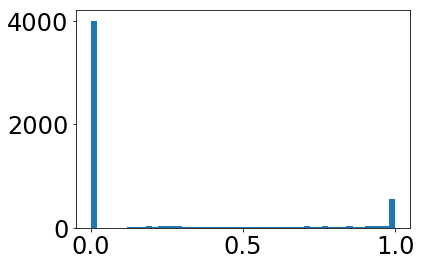

In [68]:
attenuation = 1 # 1 means no attenuation
r0=2.5
seeds = get_seeds(nodesc,100)
probs = outbreak.get_outbreaks(F, seeds.incidence, R0=r0, attenuate=attenuation)
plt.hist(probs, bins=50);

In [69]:
nodesc['probs'] = probs
mapap = pd.merge(mapa, nodesc, left_on='code_muni', right_on='tgt')

## Visualizing with Pydeck

In [40]:
DATA = ujson.loads(mapap[mapap.probs>0.5].to_json())

In [42]:

LAND_COVER = [[[-54.291, -14.139], [-54.39180562, -14.23962137], [-54.39180562, -14.23962137], [-54.291, -14.139]]]

INITIAL_VIEW_STATE = pydeck.ViewState(
  latitude=-14.23962137,
  longitude= -54.39180562,
  zoom=3,
  max_zoom=16,
  pitch=45,
  bearing=0
)

polygon = pydeck.Layer(
    'PolygonLayer',
    LAND_COVER,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon='-',
    get_fill_color=[0, 0, 0, 20]
)

geojson = pydeck.Layer(
    'GeoJsonLayer',
    DATA,
    opacity=0.8,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
#     mapbox_key='pk.eyJ1IjoiZmNjb2VsaG8iLCJhIjoiY2s4c293dzc3MGJodzNmcGEweTgxdGpudyJ9.UmSRs3e4EqTOte6jYWoaxg',
    get_elevation='properties.casos',
    get_fill_color='[properties.probs *255, 255*(1-properties.probs), properties.probs * 255]',
    get_line_color=[255, 255, 255],
    pickable=True
)

r = pydeck.Deck(
    layers=[polygon,geojson],
    initial_view_state=INITIAL_VIEW_STATE)

r.to_html()

'/home/fccoelho/Mega/Papers/Covid-19-epigrass/covid-19/Modelagem Epi/pydeck5x4bpbc8.html'

In [25]:
cents = mapap.centroid
data2 = mapap[['casos','probs']]
data2['lon'] = [p.x for p in cents]
data2['lat'] = [p.y for p in cents]
# data2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [63]:
layer = pydeck.Layer(
    'HexagonLayer',  # `type` positional argument is here
    data2,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    elevation_scale=50,
    lower_percentile=0.8,
#     elevation_upper_percentile=1,
    get_elevation='points.probs',
    radius=3000,
    pickable=True,
    elevation_range=[0, 3000],
    extruded=True,
    coverage=3)

# Set the viewport location
view_state = pydeck.ViewState(
    longitude=-54.39180562,
    latitude=-14.23962137,
    zoom=3,
    min_zoom=3,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

# Combined all of it and render a viewport
r = pydeck.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('hexagon-probs.html')

'/home/fccoelho/Documentos/Software projects/covidash/notebooks/hexagon-probs.html'

In [43]:
pydeck.Layer?

## Creating Animation

In [70]:
cases.date = pd.to_datetime(cases.date).dt.date
casesm = cases[(cases.place_type=='city')&(~cases.city_ibge_code.isnull())]
casesm['city_ibge_code'] = casesm.city_ibge_code.astype(int)
casesm = casesm[casesm.city_ibge_code!=0]
# casesm.fillna(0, inplace=True)
len(set(casesm.city_ibge_code))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1164

### Creating a column for each day 
Here we apply pivot_table to cases in order to create a separate columns for each day since the beginning of the epidemic in Brasil.

In [71]:
casesw = casesm.pivot_table(index='city_ibge_code',columns='date', values='confirmed')
casesw.fillna(0, inplace=True)
# casesw.drop([0], inplace=True) #remove line with geocode 0.0
casesw

date            2020-02-25  2020-02-26  2020-02-27  2020-02-28  2020-02-29  \
city_ibge_code                                                               
1100023                0.0         0.0         0.0         0.0         0.0   
1100114                0.0         0.0         0.0         0.0         0.0   
1100122                0.0         0.0         0.0         0.0         0.0   
1100155                0.0         0.0         0.0         0.0         0.0   
1100205                0.0         0.0         0.0         0.0         0.0   
...                    ...         ...         ...         ...         ...   
5221403                0.0         0.0         0.0         0.0         0.0   
5221601                0.0         0.0         0.0         0.0         0.0   
5221858                0.0         0.0         0.0         0.0         0.0   
5222005                0.0         0.0         0.0         0.0         0.0   
5300108                0.0         0.0         0.0         0.0         0.0   

date            2020-03-01  2020-03-02  2020-03-03  2020-03-04  2020-03-05  \
city_ibge_code                                                               
1100023                0.0         0.0         0.0         0.0         0.0   
1100114                0.0         0.0         0.0         0.0         0.0   
1100122                0.0         0.0         0.0         0.0         0.0   
1100155                0.0         0.0         0.0         0.0         0.0   
1100205                0.0         0.0         0.0         0.0         0.0   
...                    ...         ...         ...         ...         ...   
5221403                0.0         0.0         0.0         0.0         0.0   
5221601                0.0         0.0         0.0         0.0         0.0   
5221858                0.0         0.0         0.0         0.0         0.0   
5222005                0.0         0.0         0.0         0.0         0.0   
5300108                0.0         0.0         0.0         0.0         0.0   

date            ...  2020-04-06  2020-04-07  2020-04-08  2020-04-09  \
city_ibge_code  ...                                                   
1100023         ...         0.0         0.0         0.0         0.0   
1100114         ...         1.0         1.0         1.0         1.0   
1100122         ...         1.0         1.0         1.0         1.0   
1100155         ...         0.0         0.0         1.0         1.0   
1100205         ...        14.0        19.0        21.0        23.0   
...             ...         ...         ...         ...         ...   
5221403         ...         1.0         1.0         2.0         2.0   
5221601         ...         0.0         0.0         0.0         0.0   
5221858         ...         6.0         6.0         6.0         6.0   
5222005         ...         0.0         1.0         1.0         1.0   
5300108         ...       485.0       503.0       509.0       527.0   

date            2020-04-10  2020-04-11  2020-04-12  2020-04-13  2020-04-14  \
city_ibge_code                                                               
1100023                2.0         2.0         7.0         0.0         7.0   
1100114                1.0         1.0         1.0         0.0         1.0   
1100122                1.0         1.0         1.0         0.0         2.0   
1100155                1.0         1.0         2.0         0.0         6.0   
1100205               23.0        25.0        27.0         0.0        49.0   
...                    ...         ...         ...         ...         ...   
5221403                2.0         3.0         3.0         3.0         4.0   
5221601                0.0         0.0         1.0         0.0         0.0   
5221858                6.0         6.0         6.0         6.0         6.0   
5222005                1.0         1.0         1.0         1.0         1.0   
5300108              556.0       592.0       618.0       641.0       651.0   

date            2020-04-15  
ci

In [72]:
mapa_serie = pd.merge(mapa,casesw, left_on='code_muni', right_on=casesw.index,how='outer')
mapa_serie.set_index('code_muni', inplace=True)
# mapa_serie.fillna(0, inplace=True)
# mapa_serie.plot();

In [73]:
attenuation = 1 # 1 means no attenuation
r0=2.5
for D in casesw.columns:
    print(f"Processing {D}...")
    nodesC = pd.merge(nodes,casesm[casesm.date==D], left_on='tgt', right_on='city_ibge_code', how='left')
    nodesC = nodesC[['tgt','tgtname','tgt_UFCOD','tgtpop','confirmed']]
    seeds = get_seeds(nodesC,100)
#     print(len(seeds.confirmed>100))
    try:
        probs = outbreak.get_outbreaks(F, seeds.incidence, R0=r0, attenuate=attenuation)
    except:
        print(seeds)
#     print(probs.max())
    cname = 'p_'+str(D)
    nodesC[cname] = probs
    mapa_serie = pd.merge(mapa_serie, nodesC[['tgt',cname]].set_index('tgt'), left_index=True,right_index=True)

Processing 2020-02-25...
Processing 2020-02-26...
Processing 2020-02-27...
Processing 2020-02-28...
Processing 2020-02-29...
Processing 2020-03-01...
Processing 2020-03-02...
Processing 2020-03-03...
Processing 2020-03-04...
Processing 2020-03-05...
Processing 2020-03-06...
Processing 2020-03-07...
Processing 2020-03-08...
Processing 2020-03-09...
Processing 2020-03-10...
Processing 2020-03-11...
Processing 2020-03-12...
Processing 2020-03-13...
Processing 2020-03-14...
Processing 2020-03-15...
Processing 2020-03-16...
Processing 2020-03-17...
Processing 2020-03-18...
Processing 2020-03-19...
Processing 2020-03-20...
Processing 2020-03-21...
Processing 2020-03-22...
Processing 2020-03-23...
Processing 2020-03-24...
Processing 2020-03-25...
Processing 2020-03-26...
Processing 2020-03-27...
Processing 2020-03-28...
Processing 2020-03-29...
Processing 2020-03-30...
Processing 2020-03-31...
Processing 2020-04-01...
Processing 2020-04-02...
Processing 2020-04-03...
Processing 2020-04-04...


In [74]:
mapa_serie.columns = [str(c) for c in mapa_serie.columns]
mapa_serie.to_file('Probability_and_case_map_daily.gpkg', driver='GPKG')

### Gerando as Figuras

In [75]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

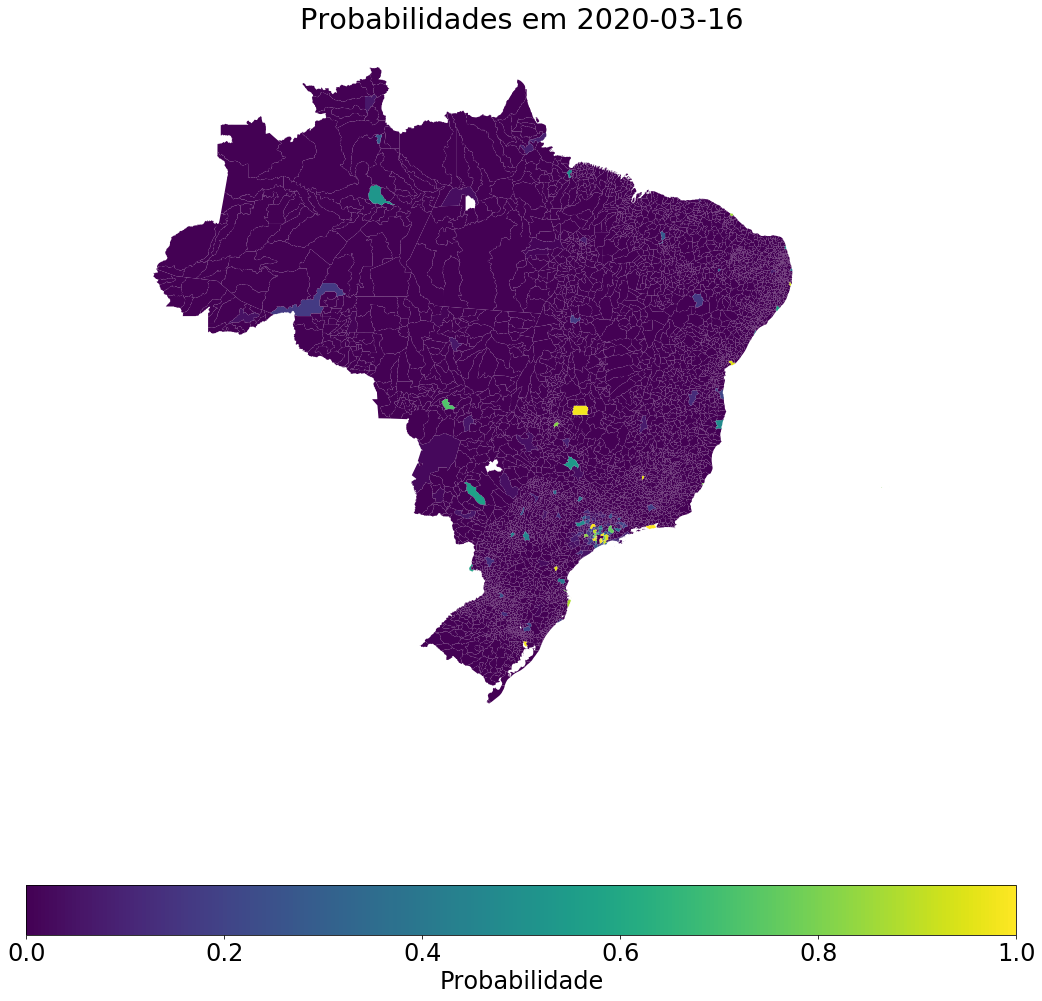

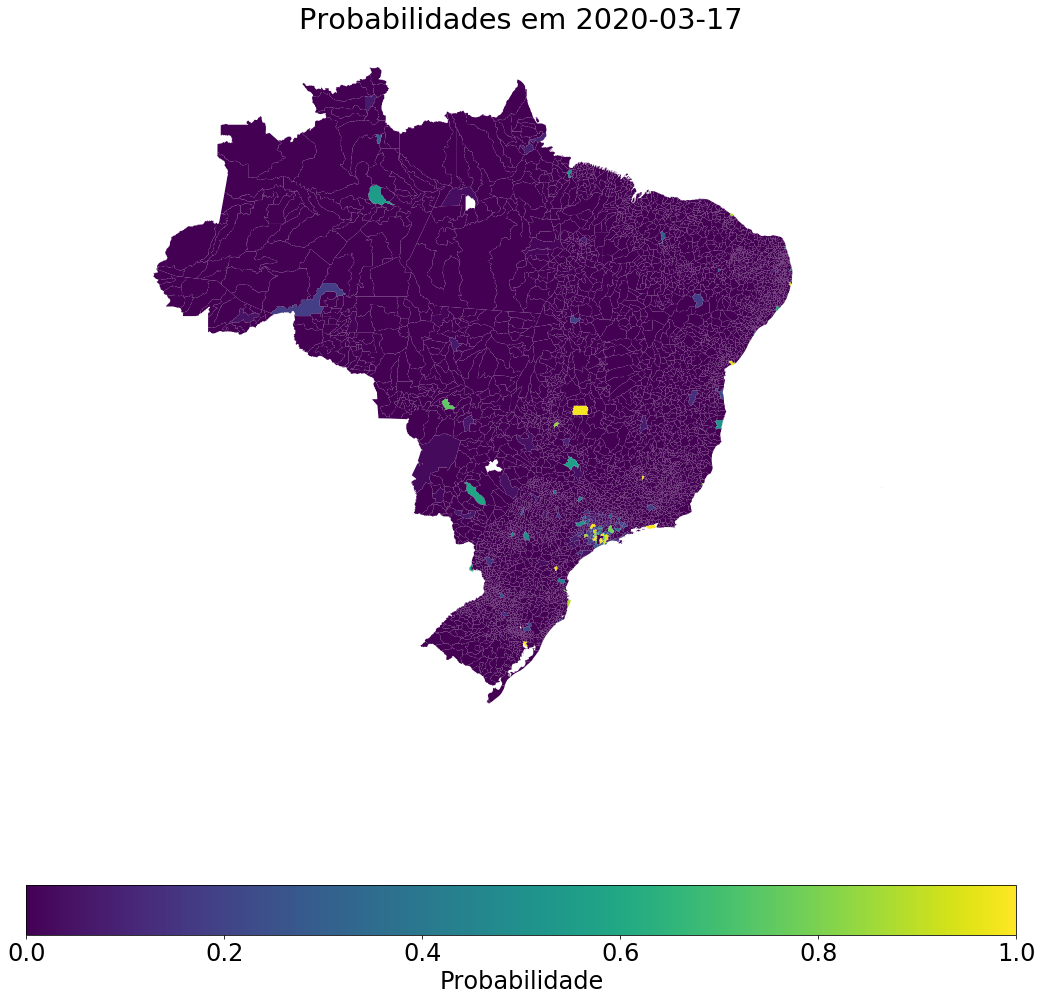

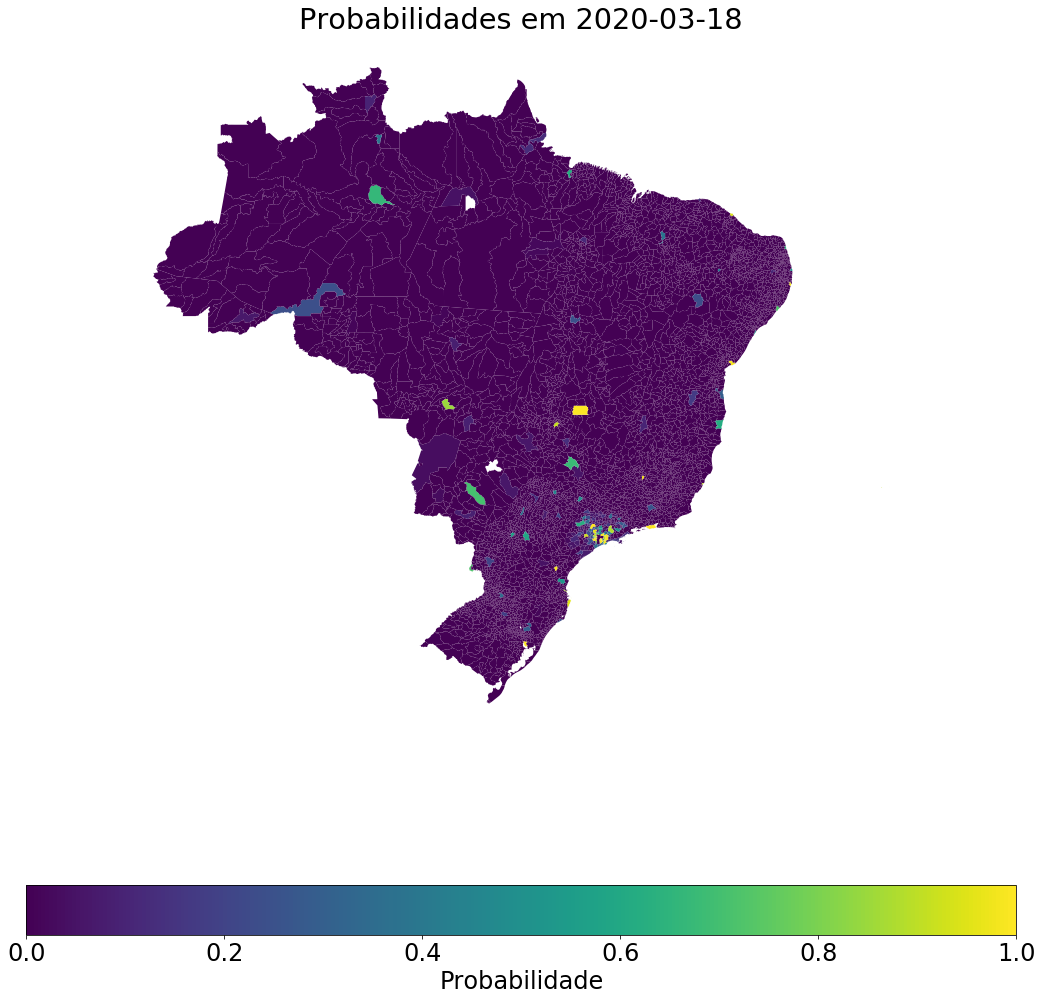

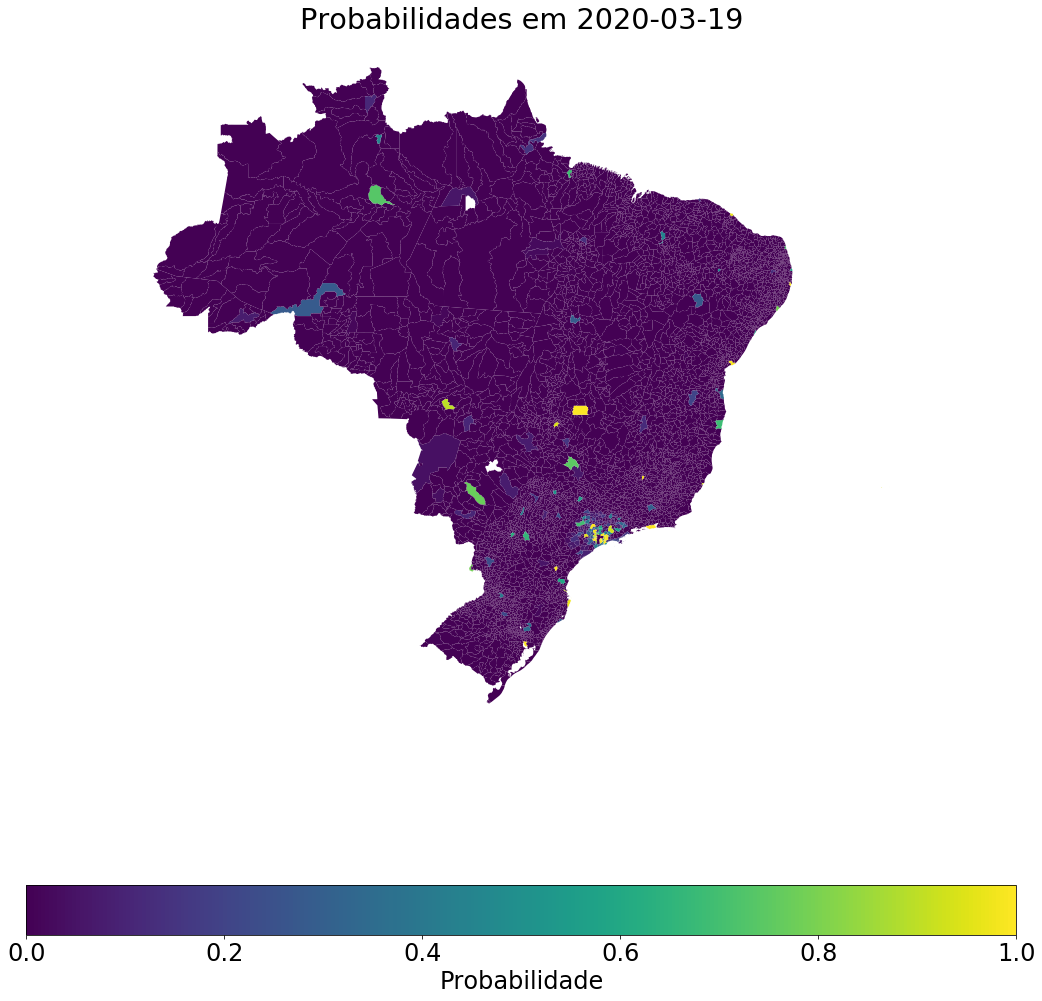

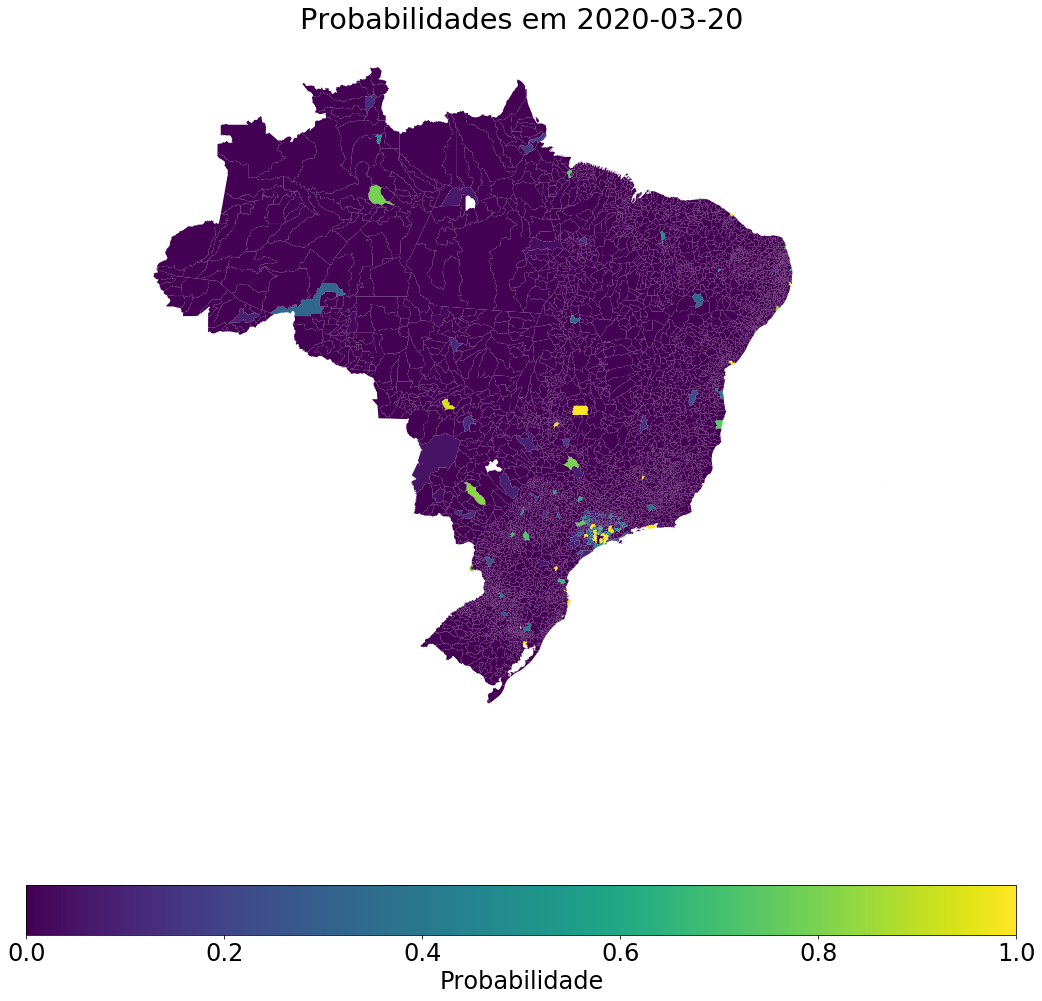

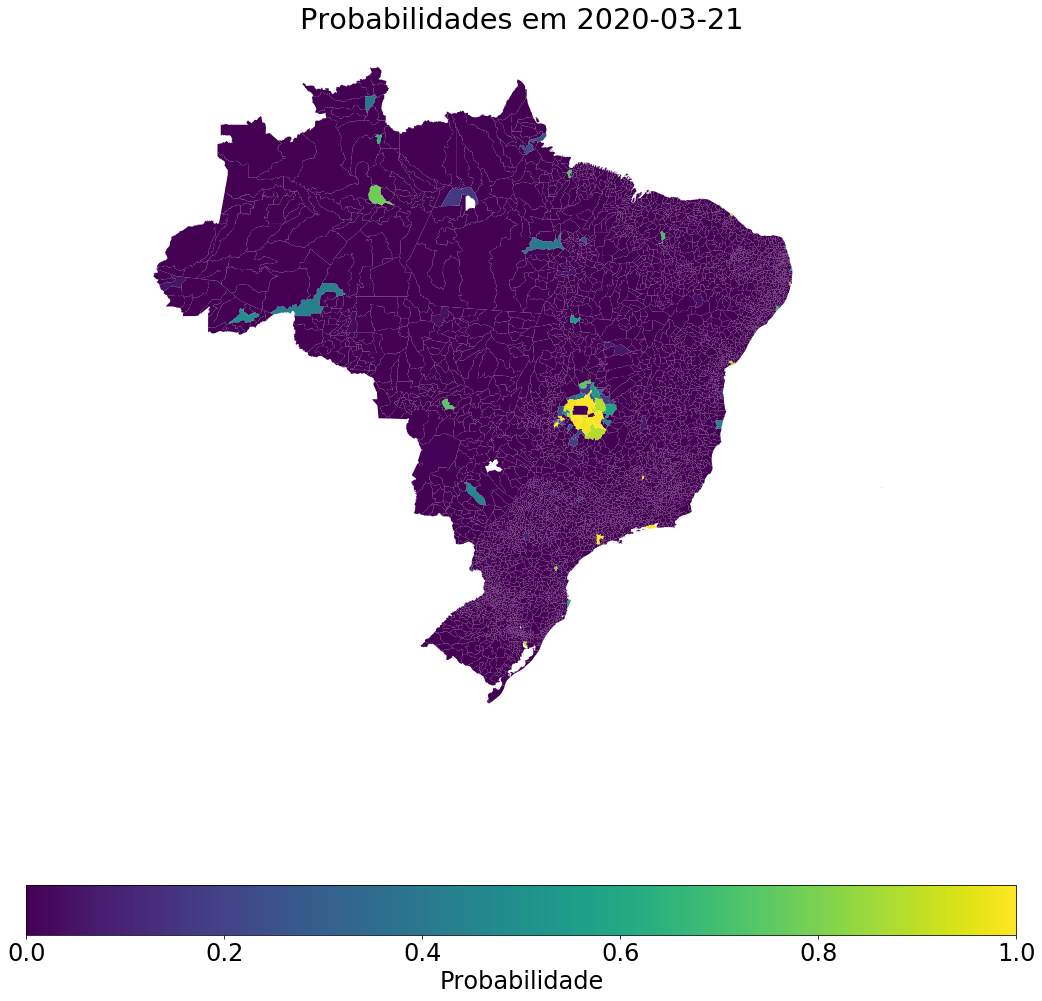

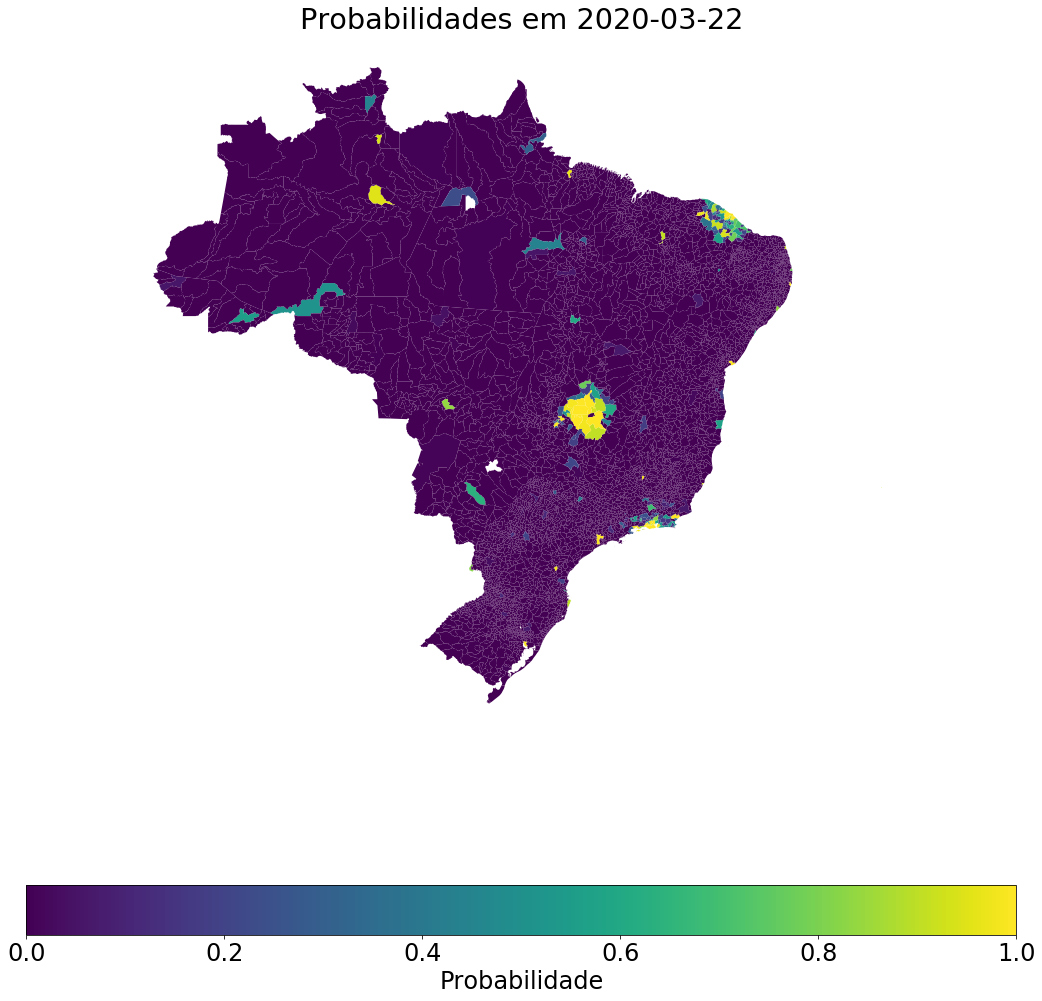

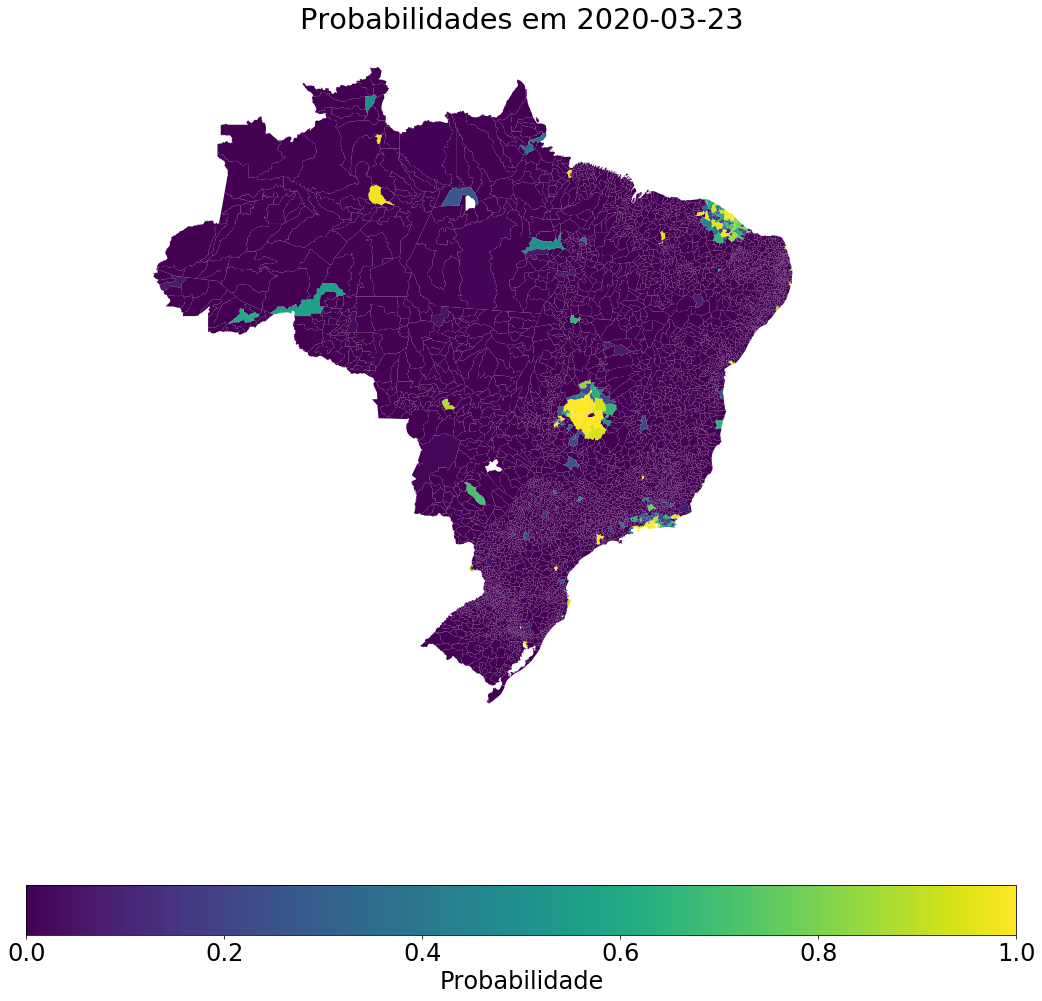

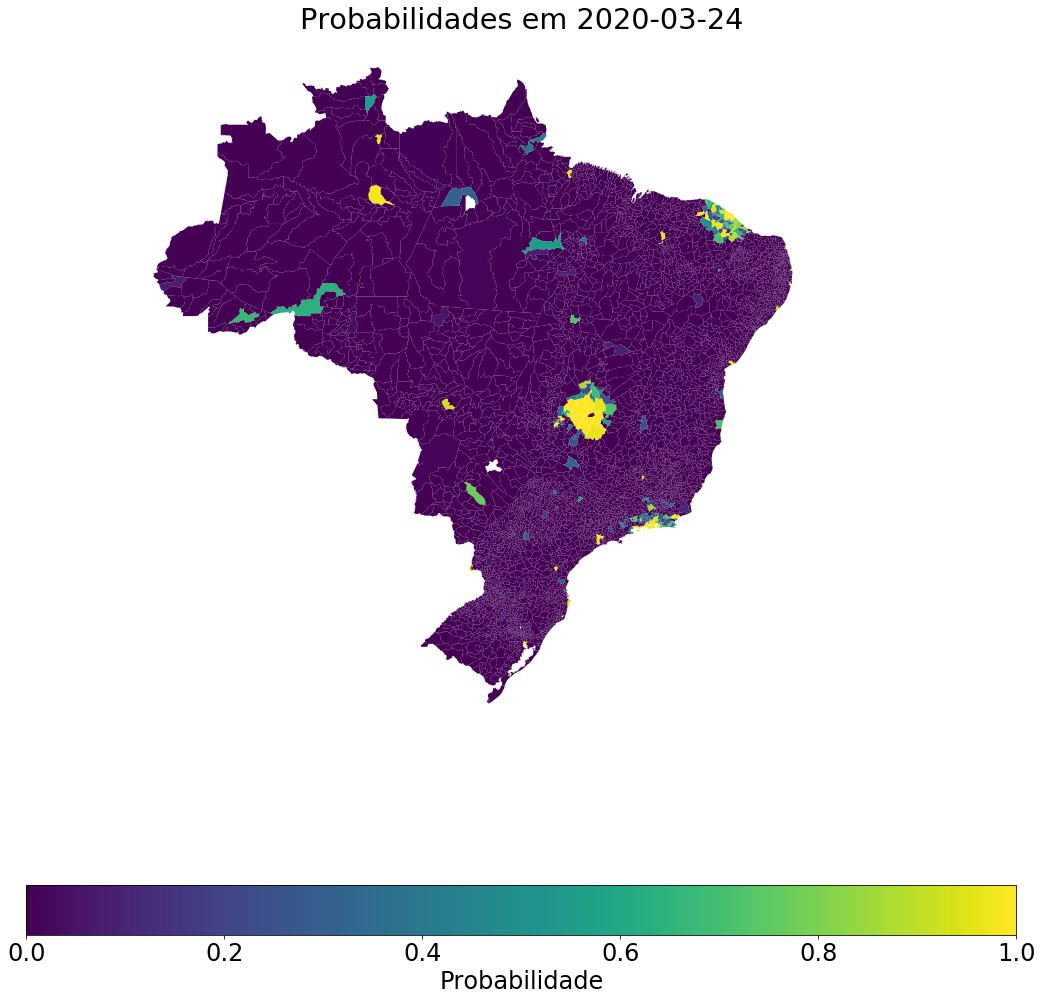

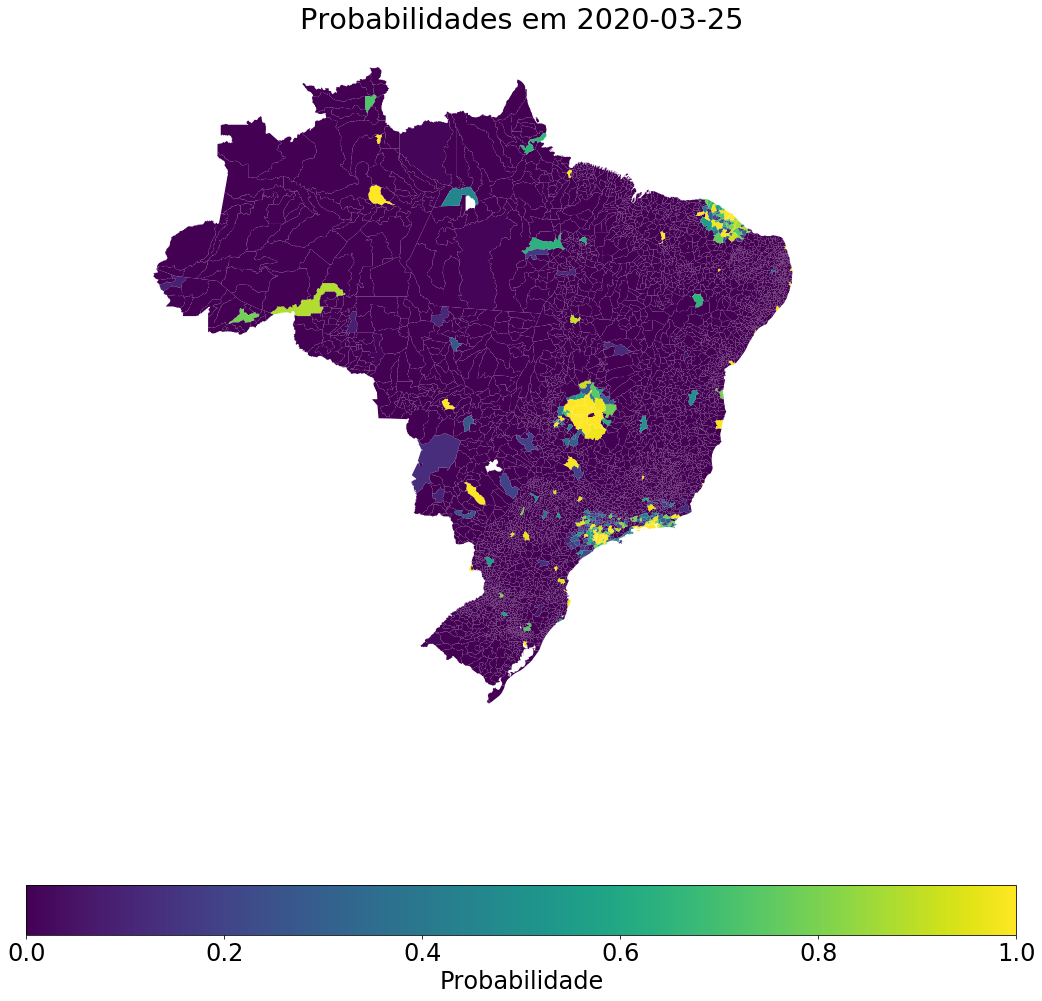

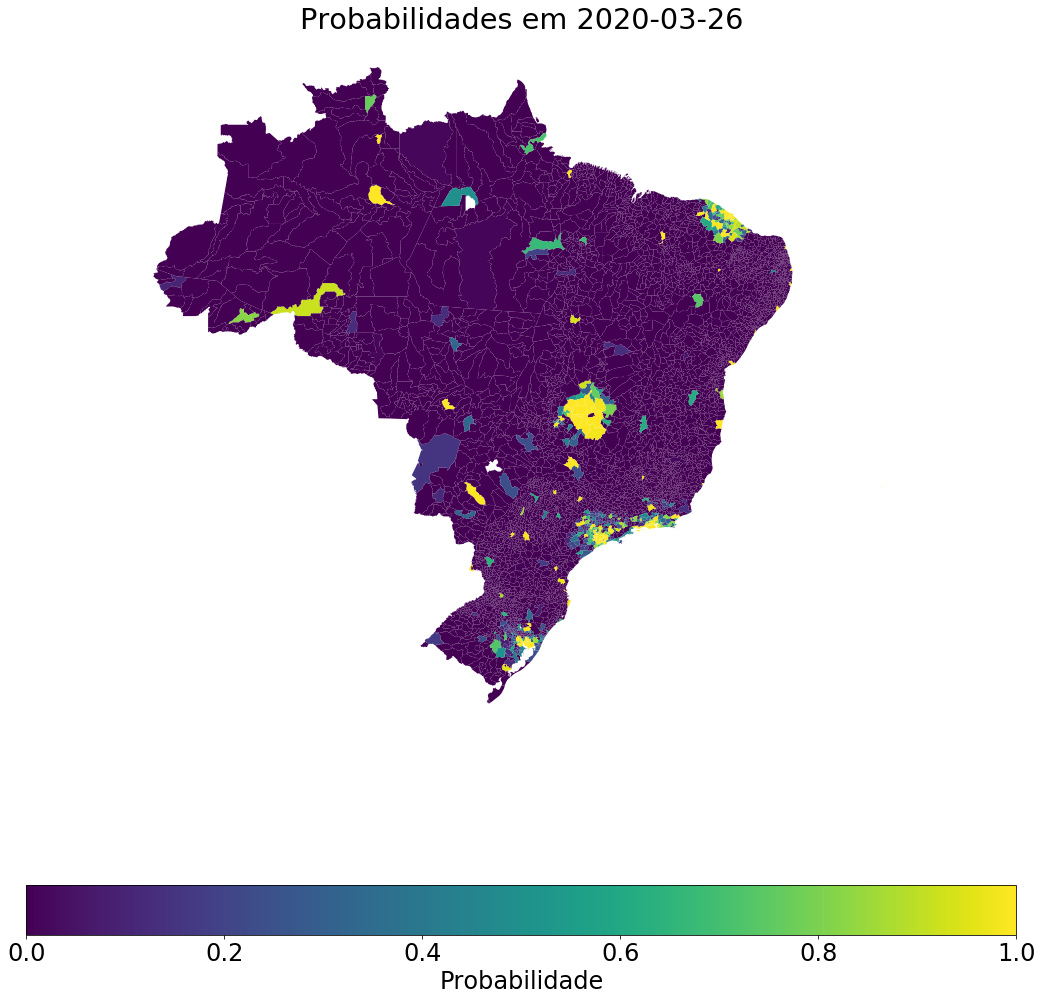

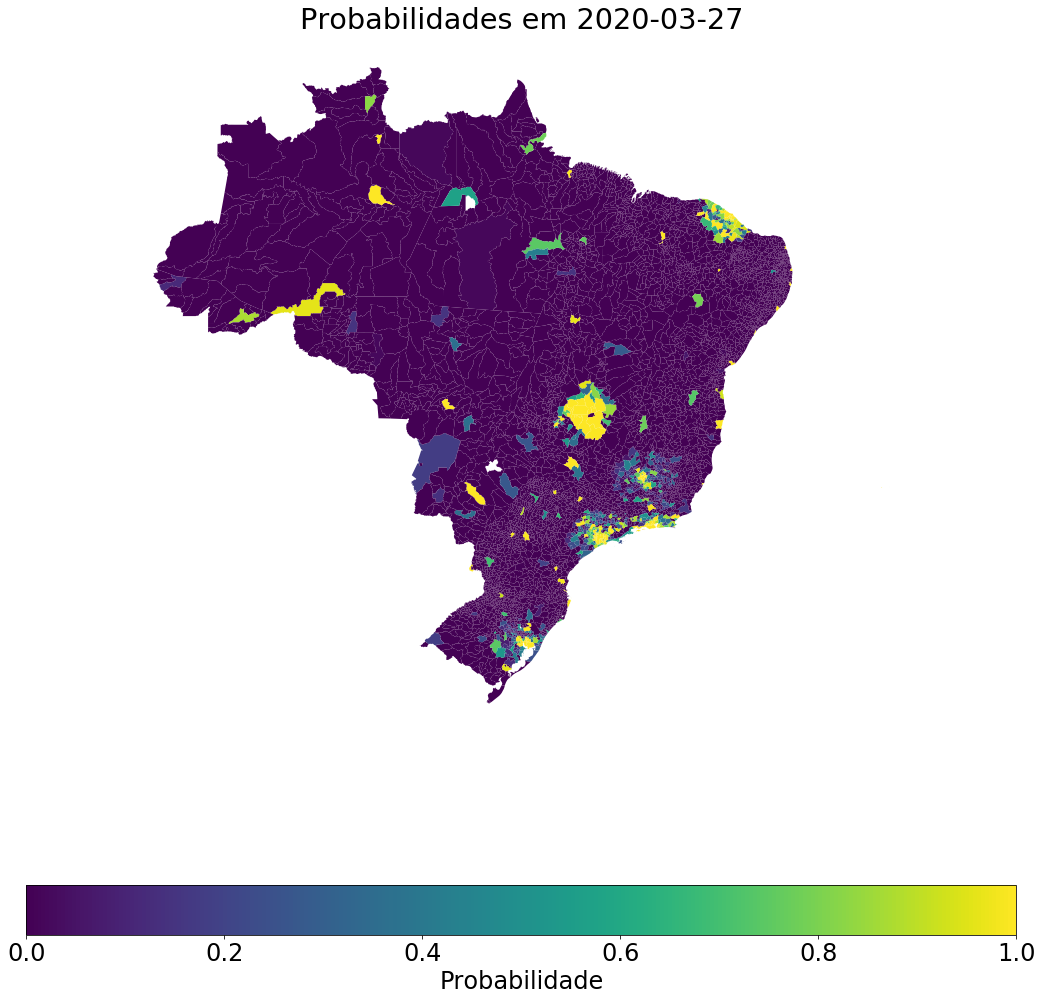

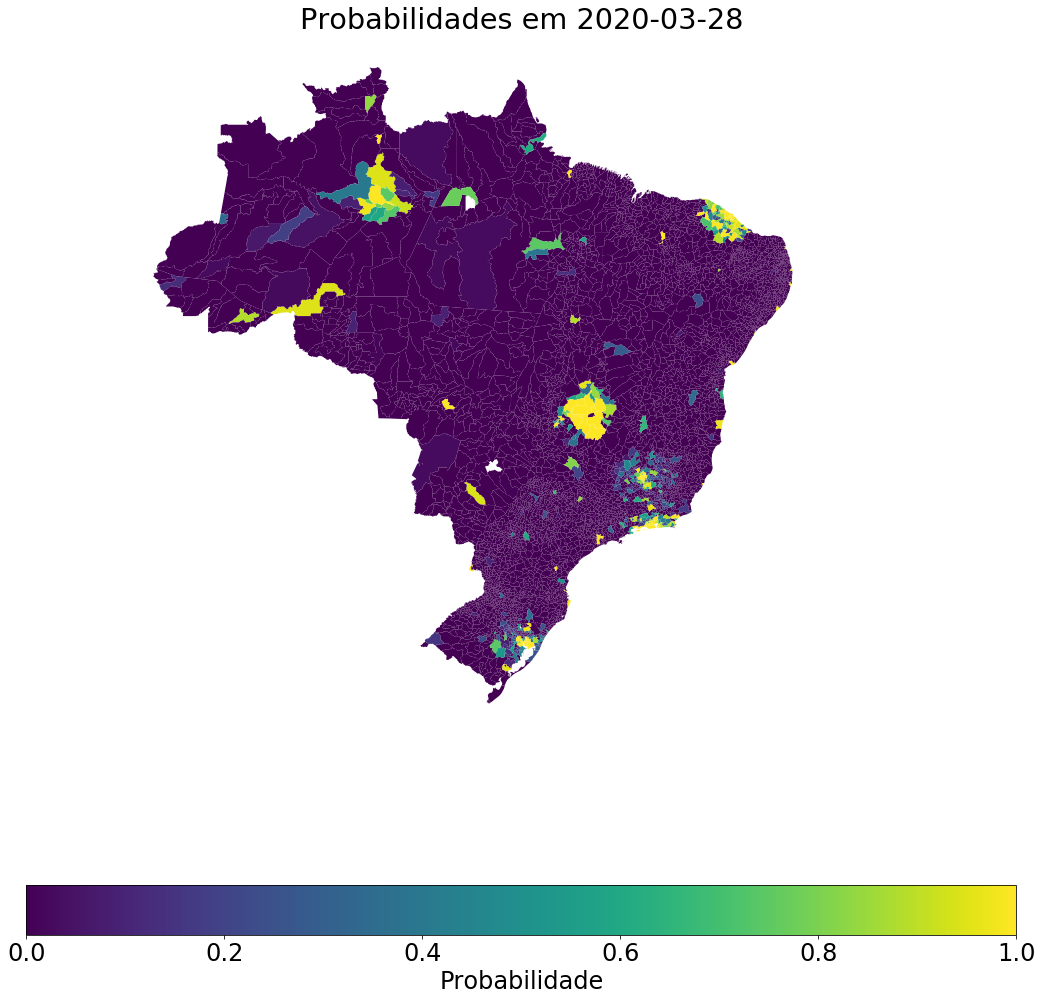

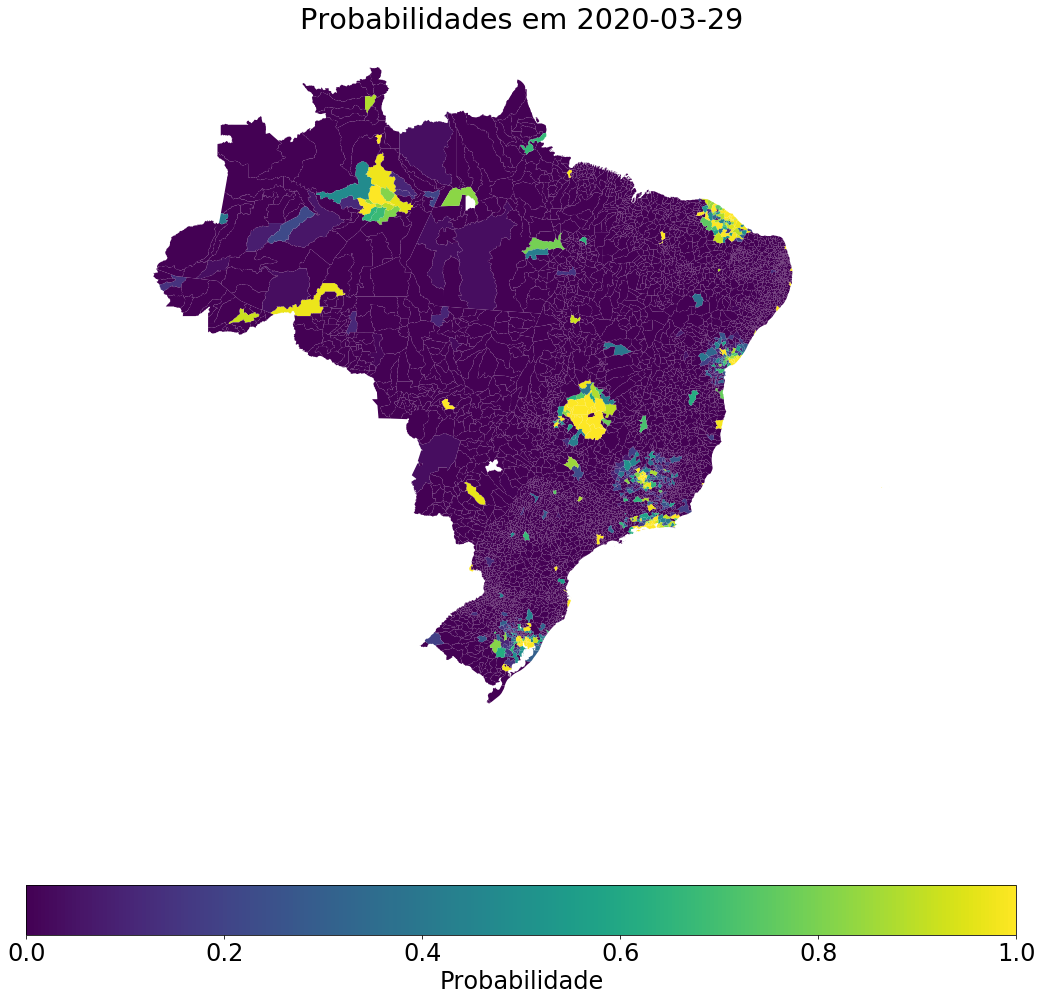

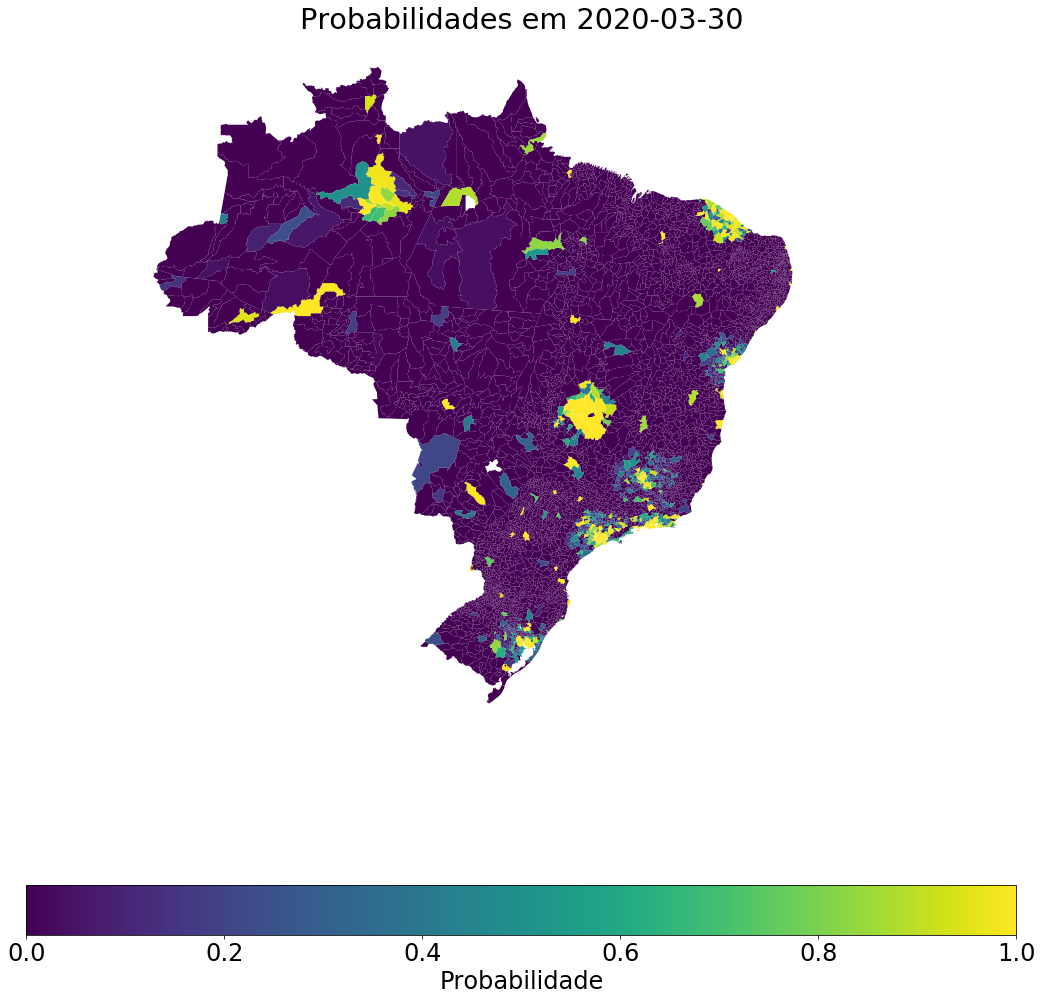

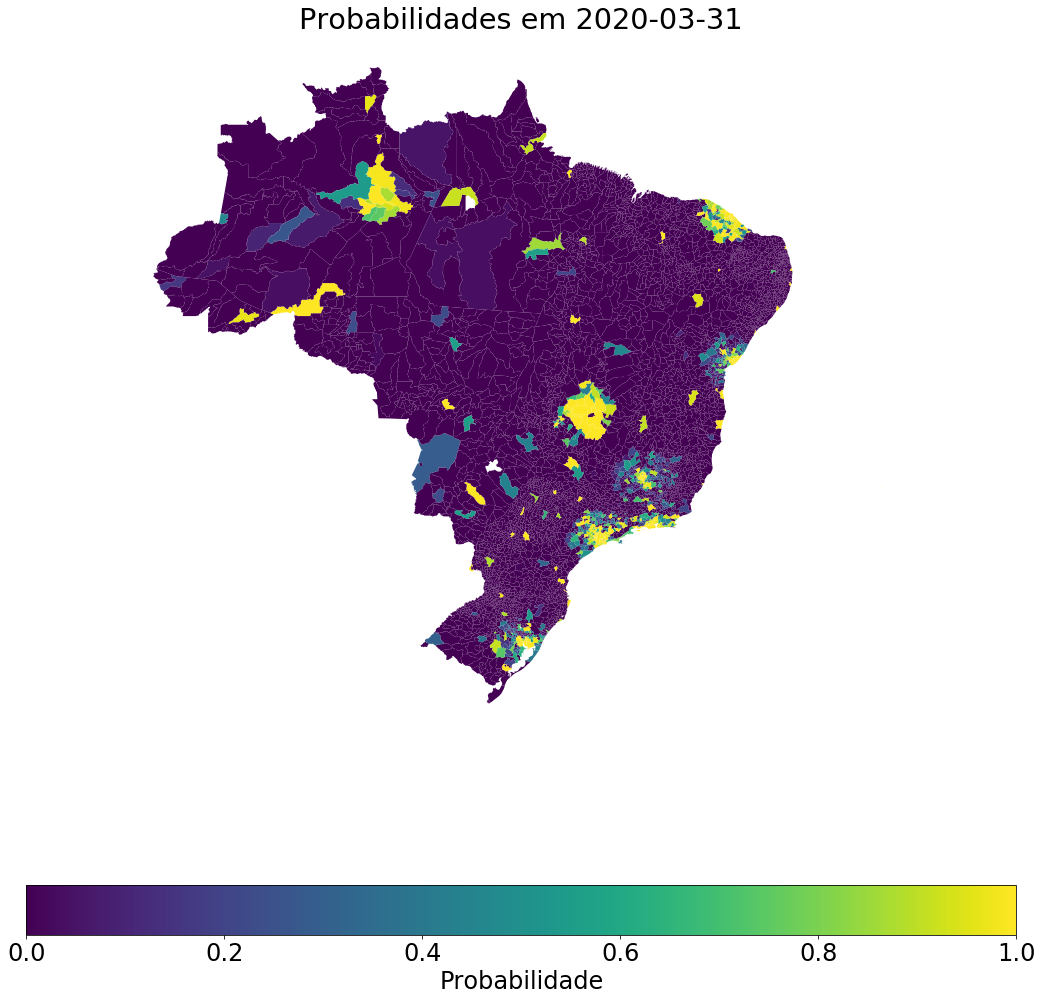

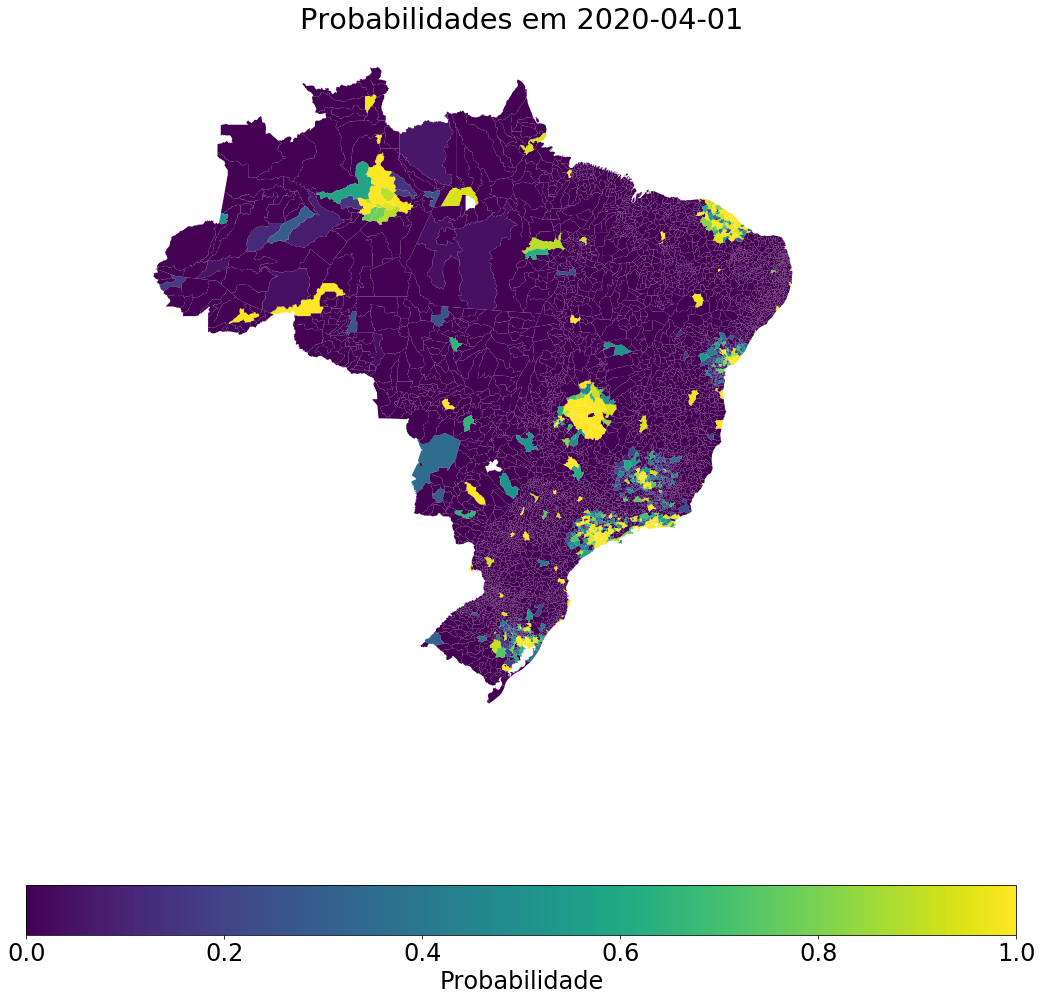

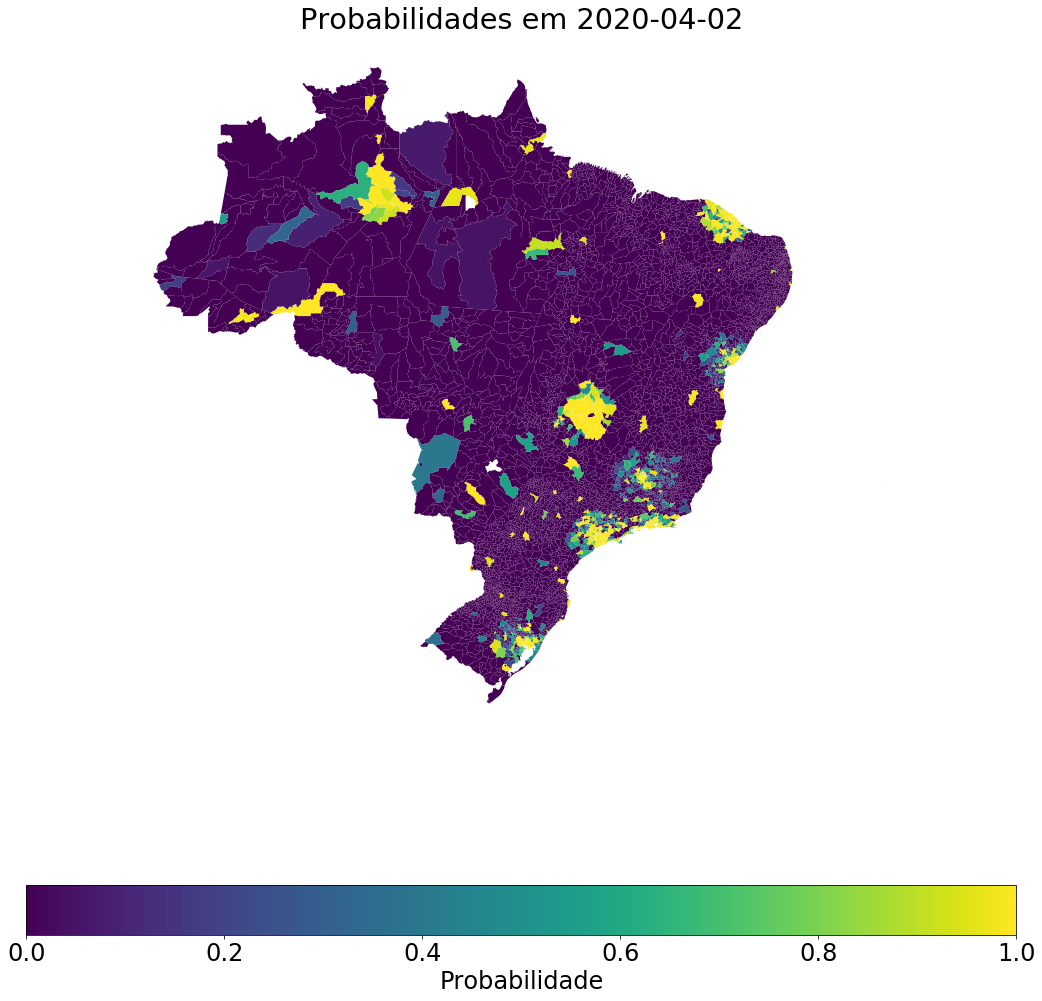

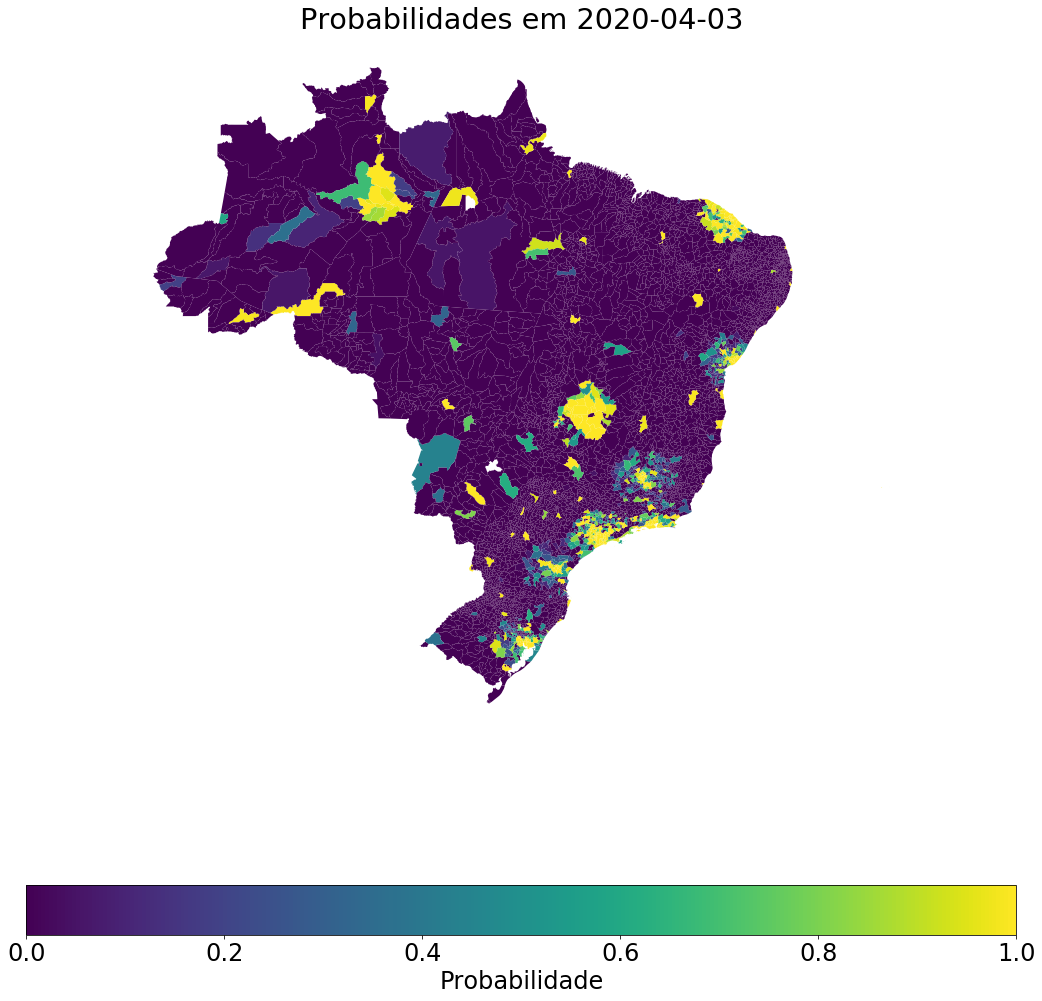

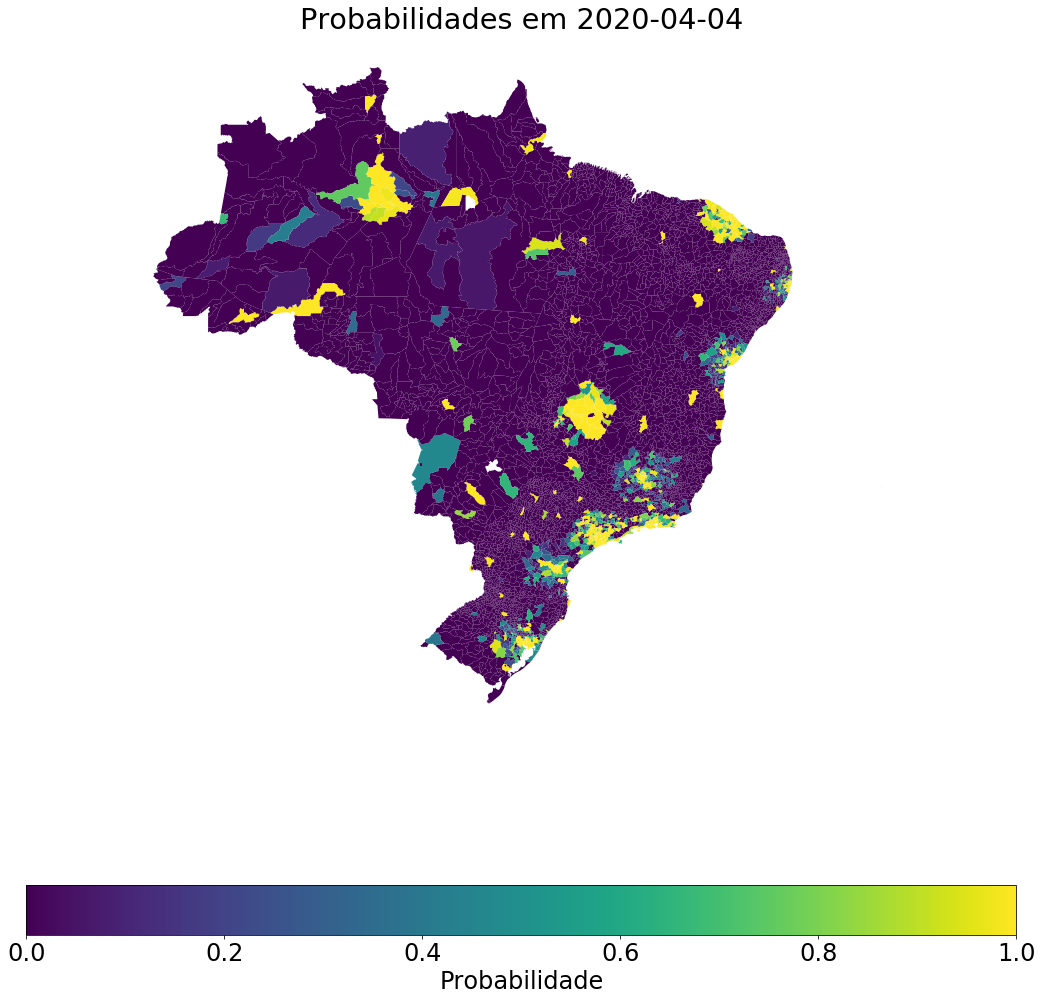

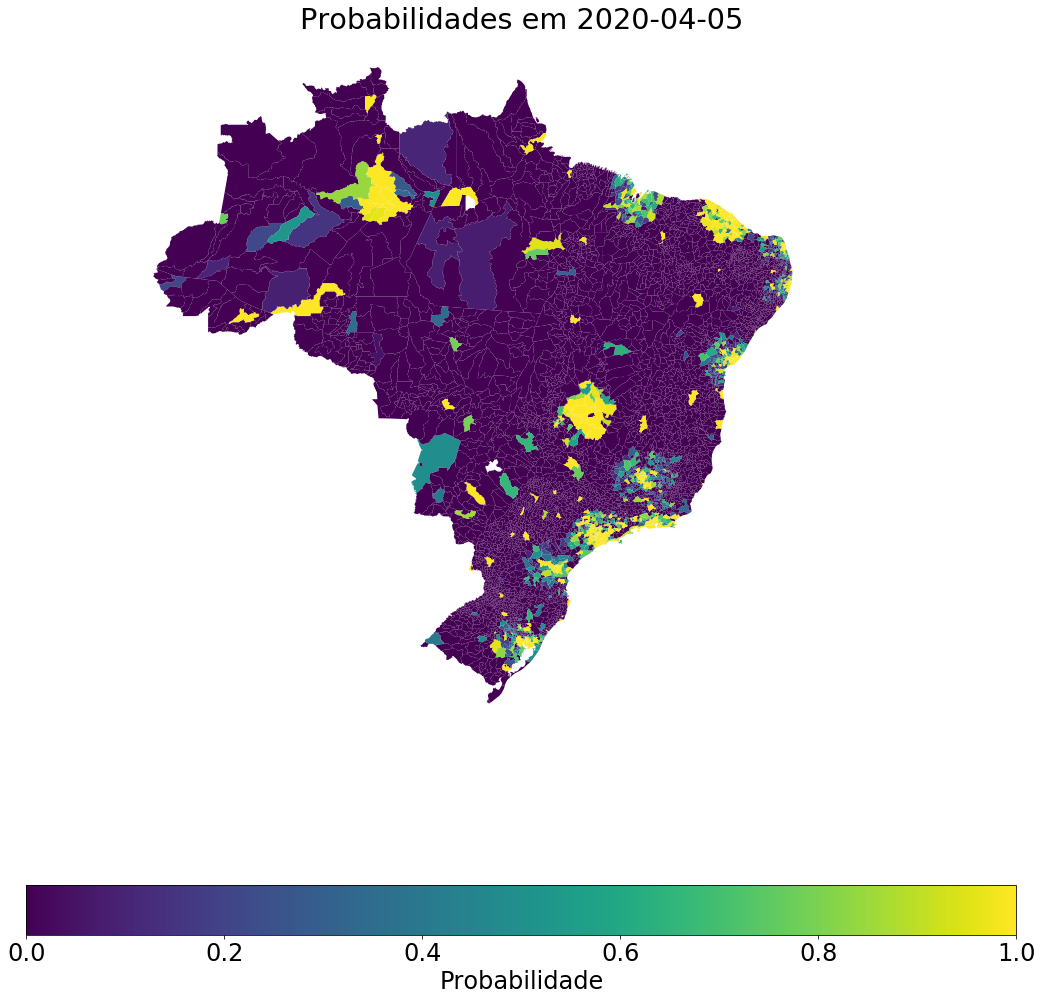

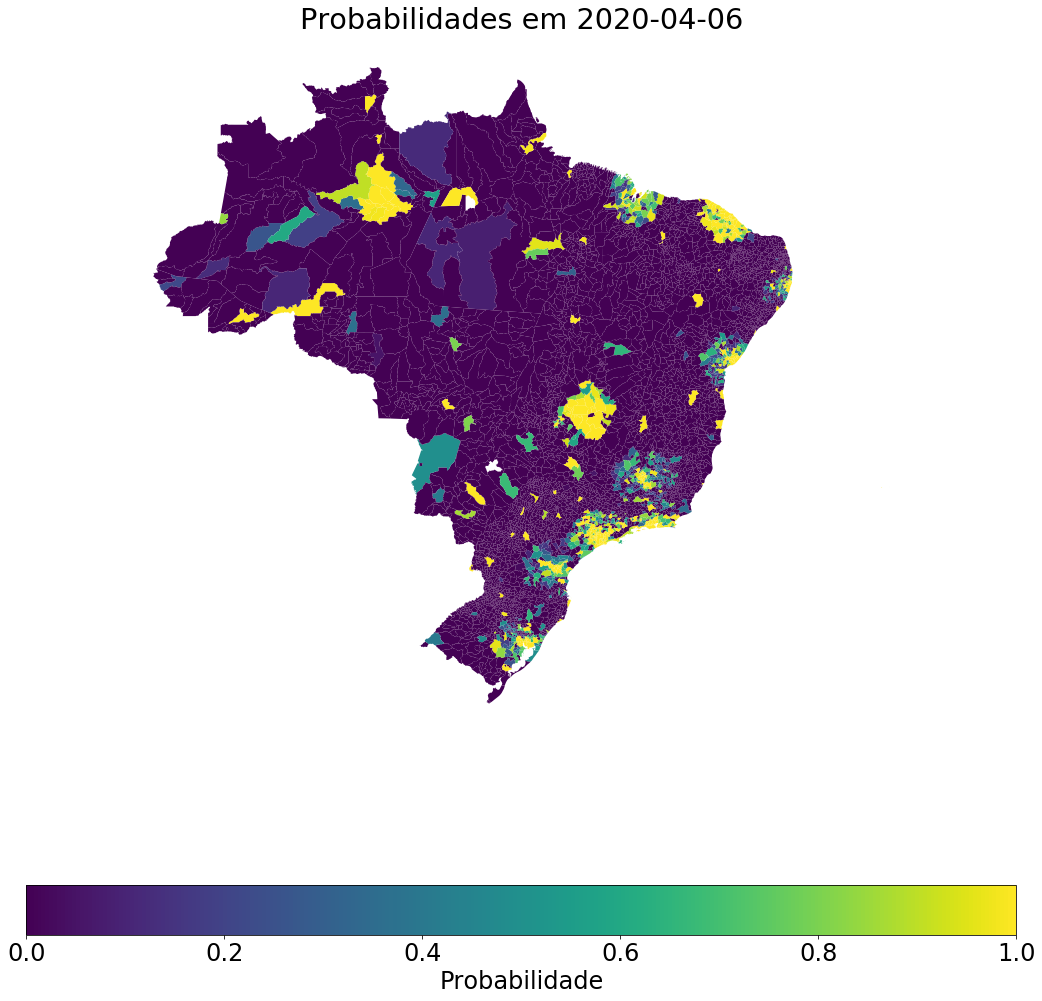

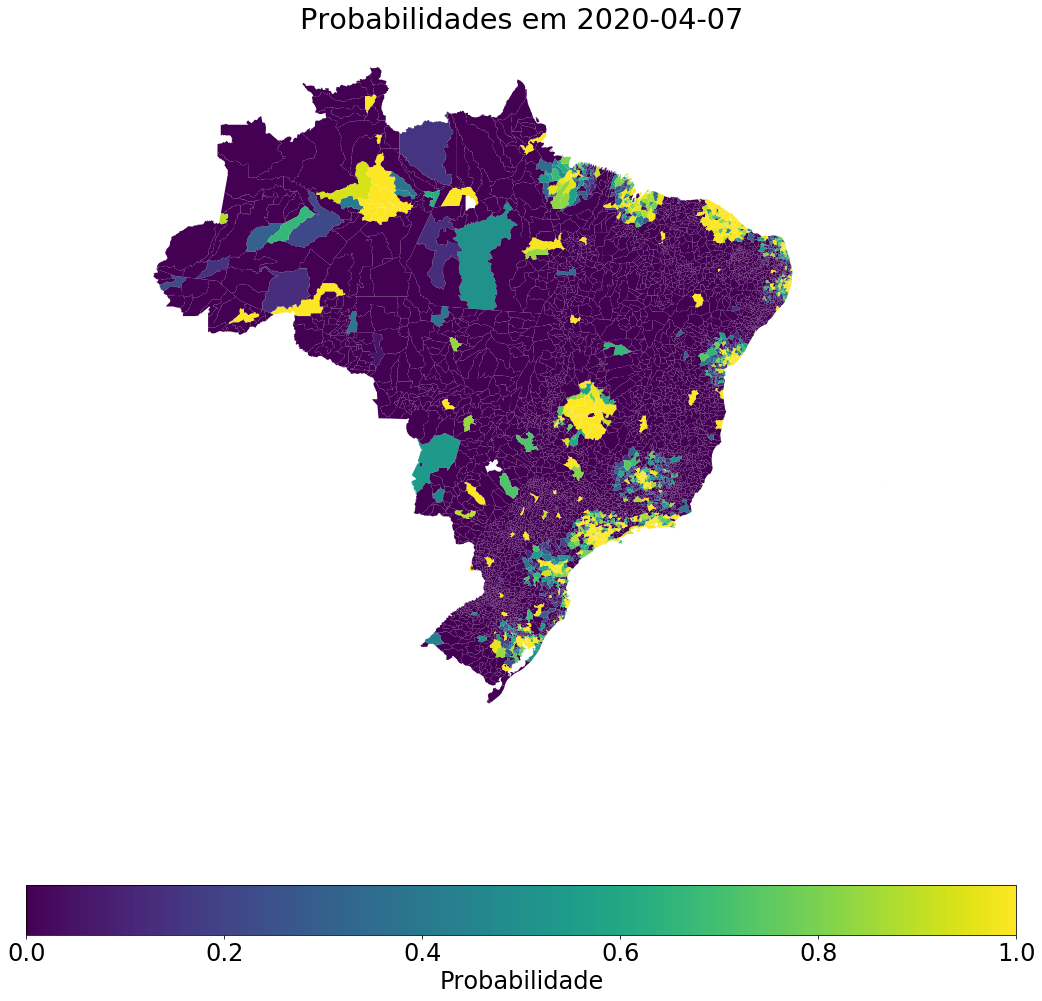

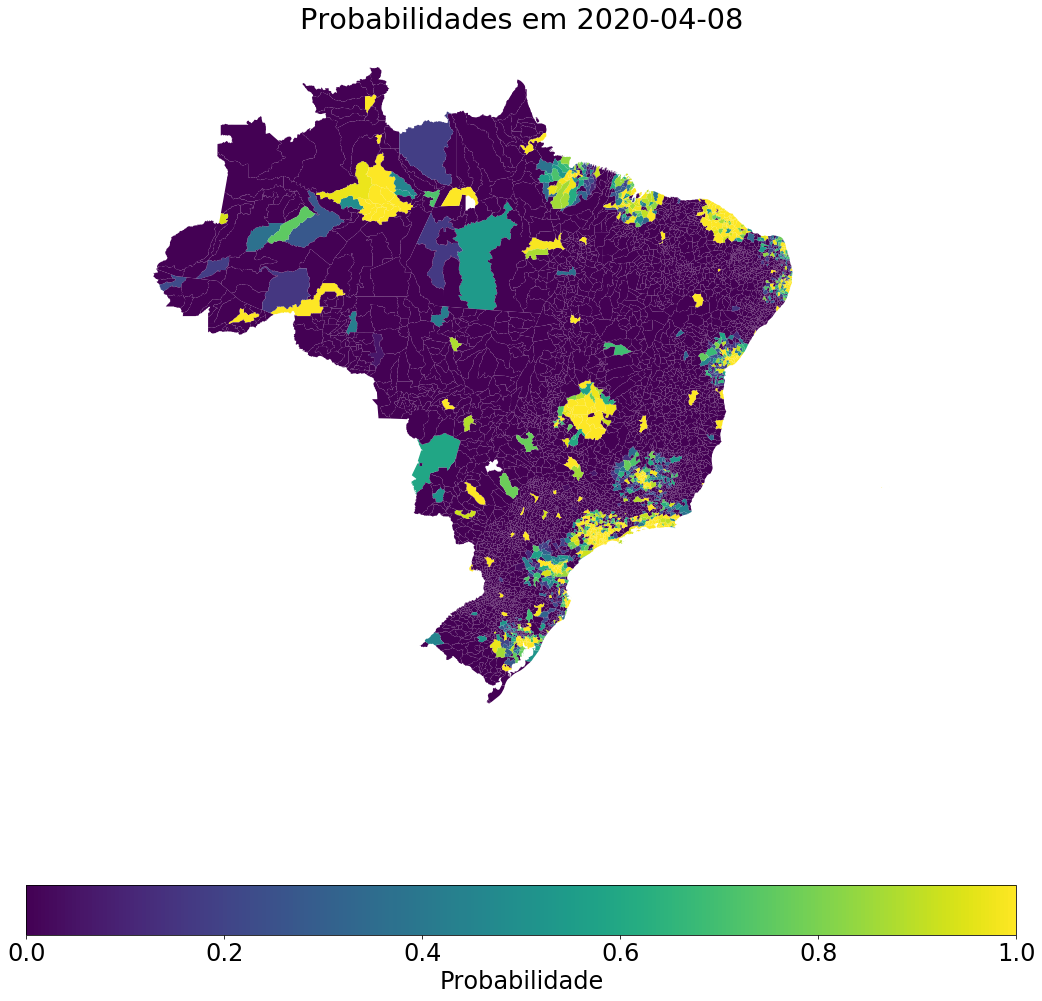

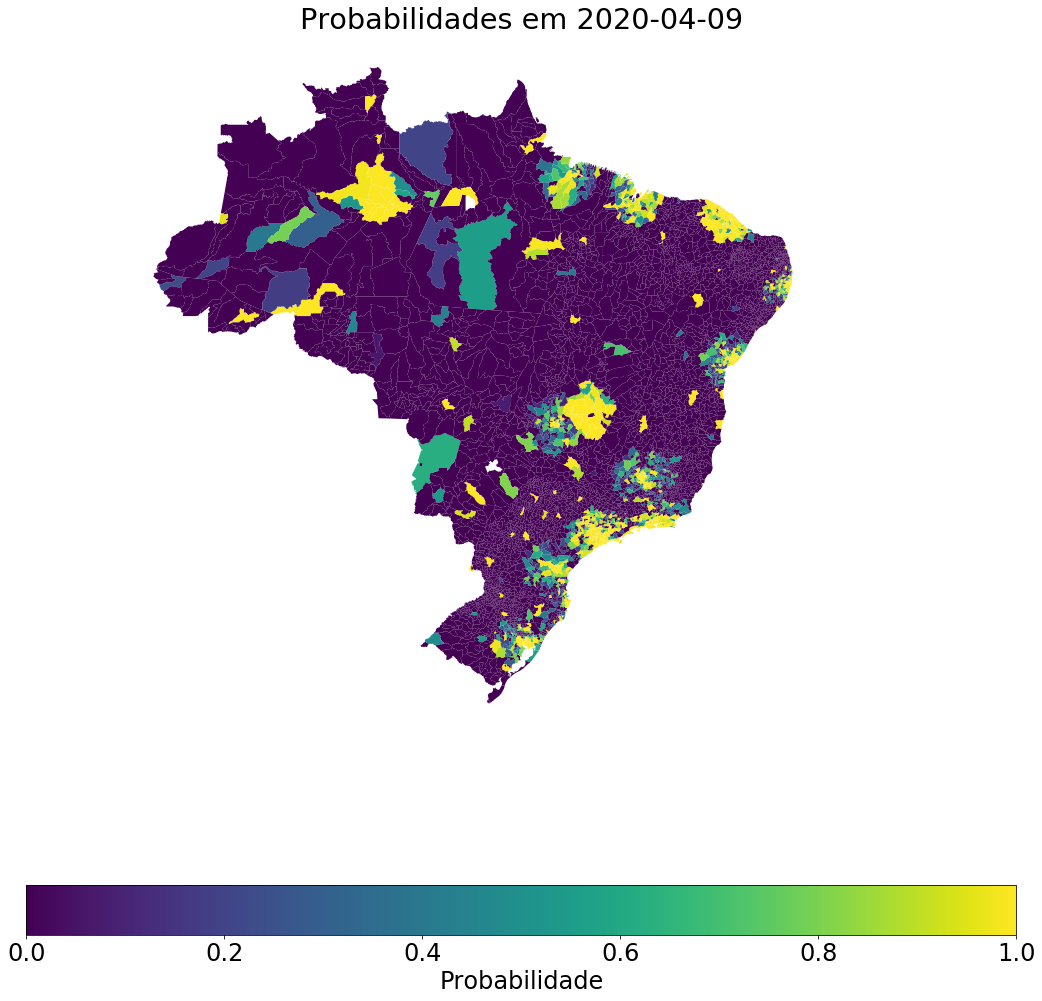

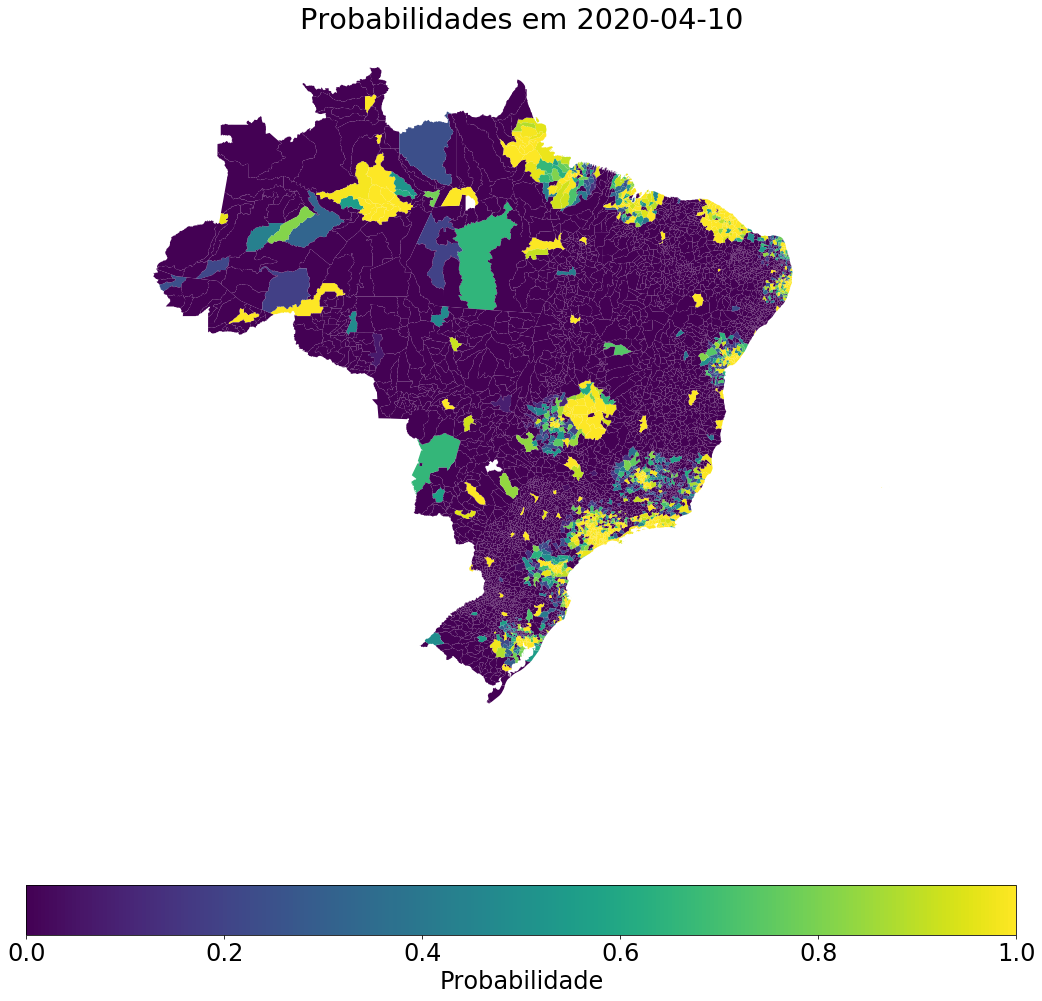

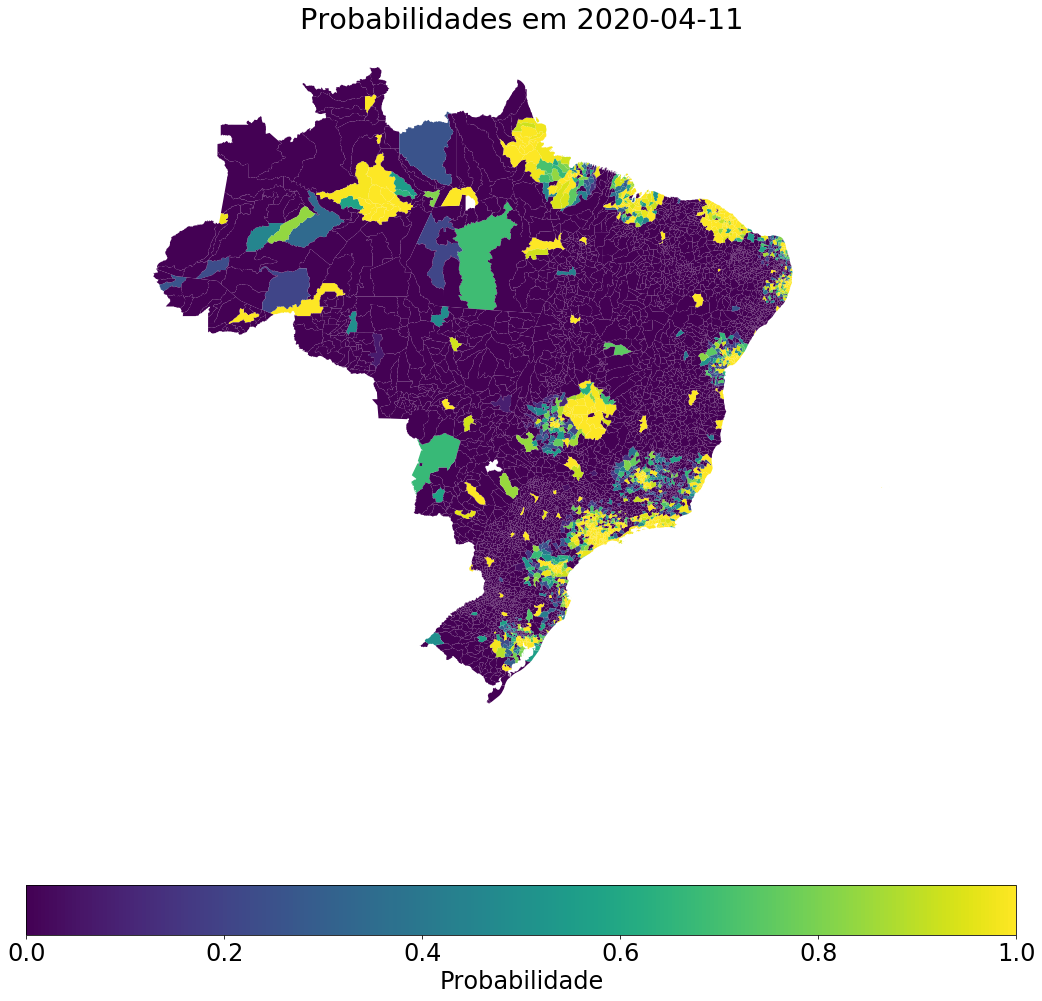

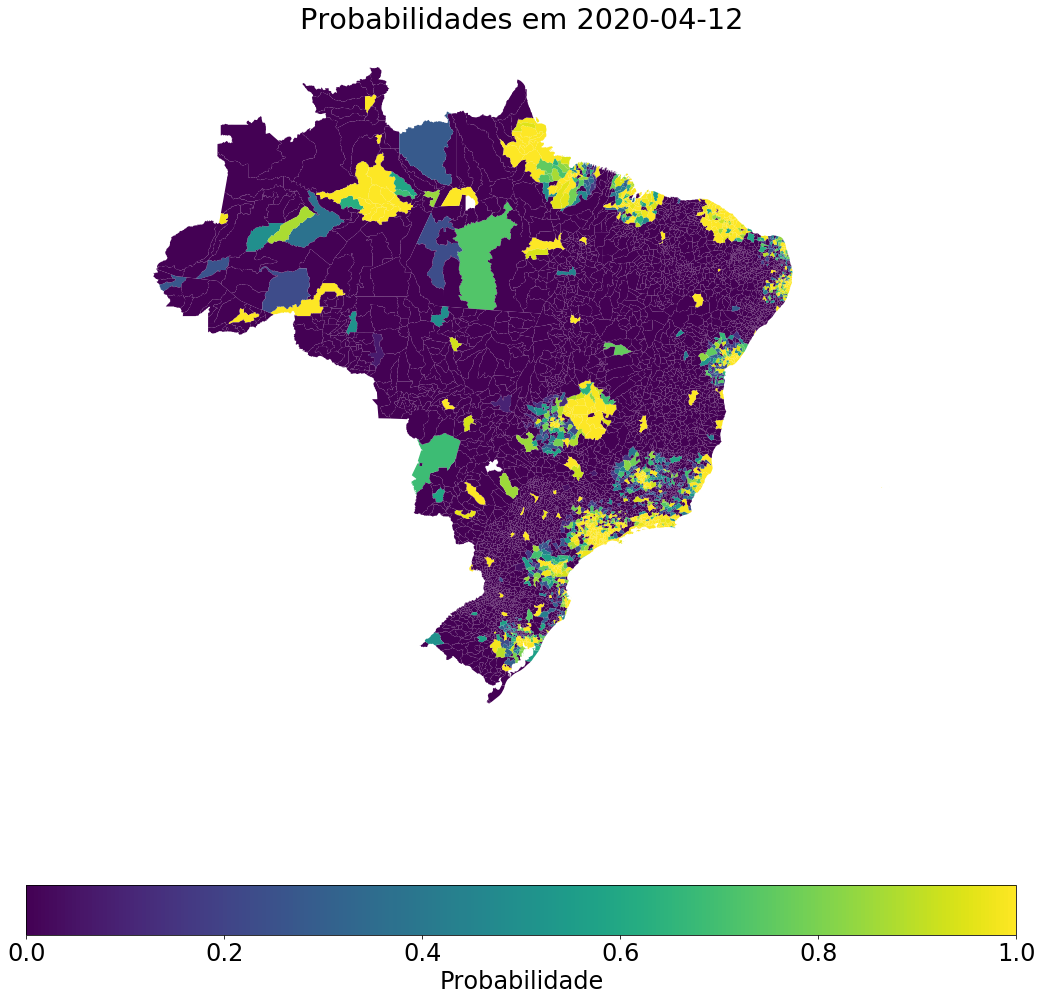

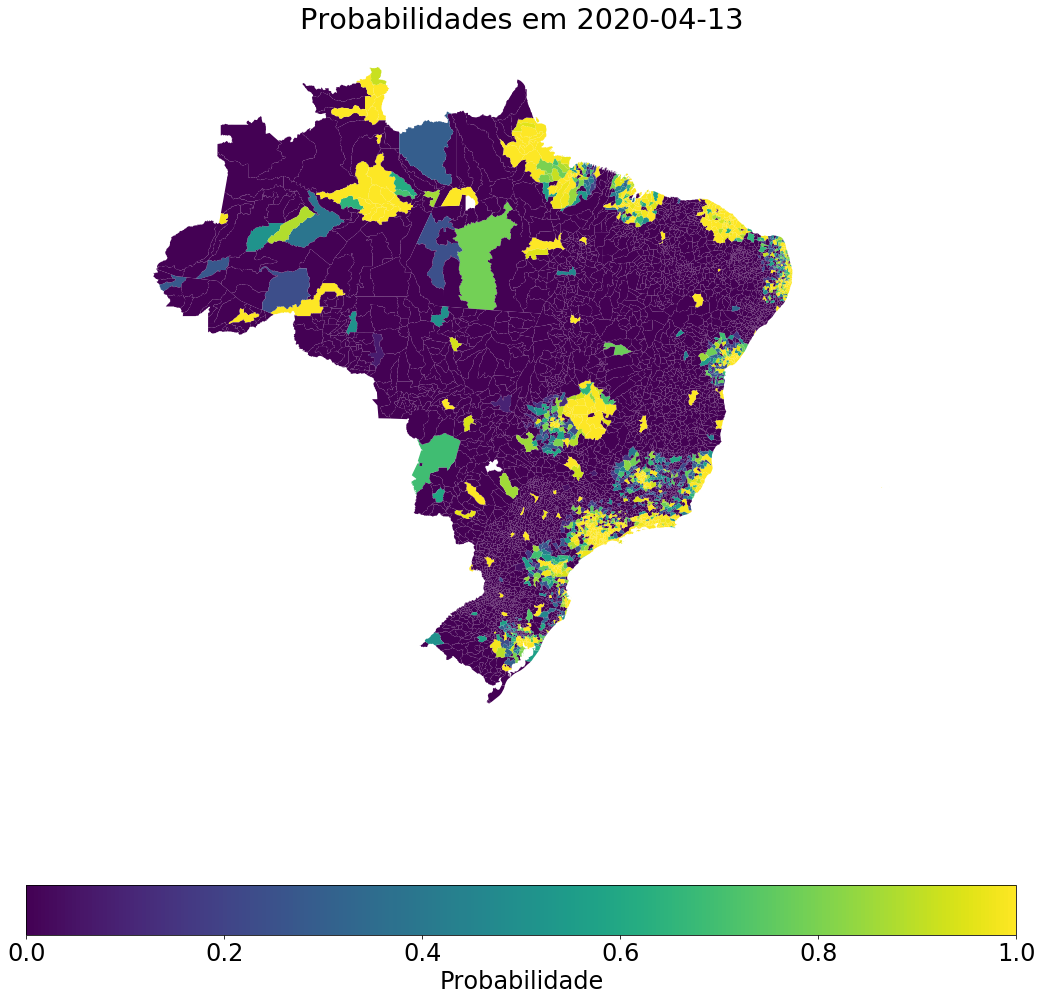

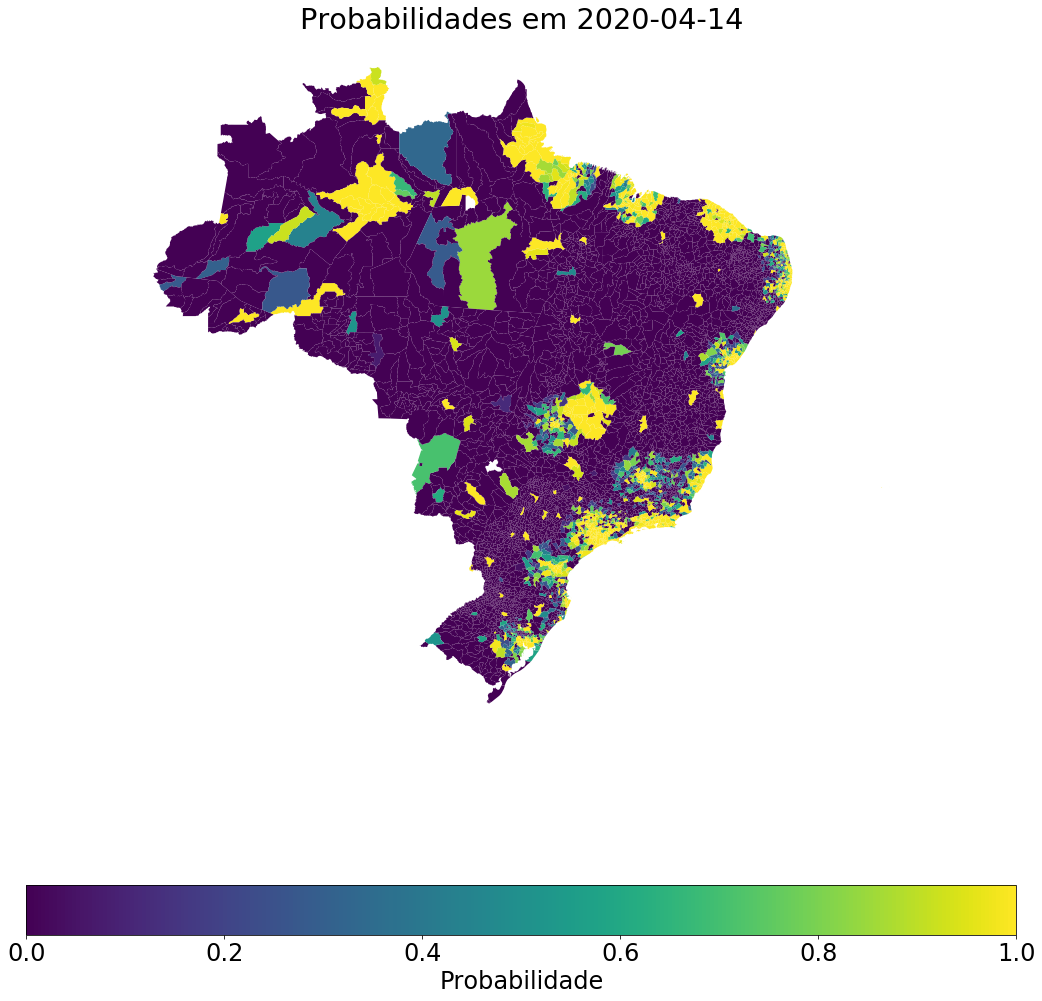

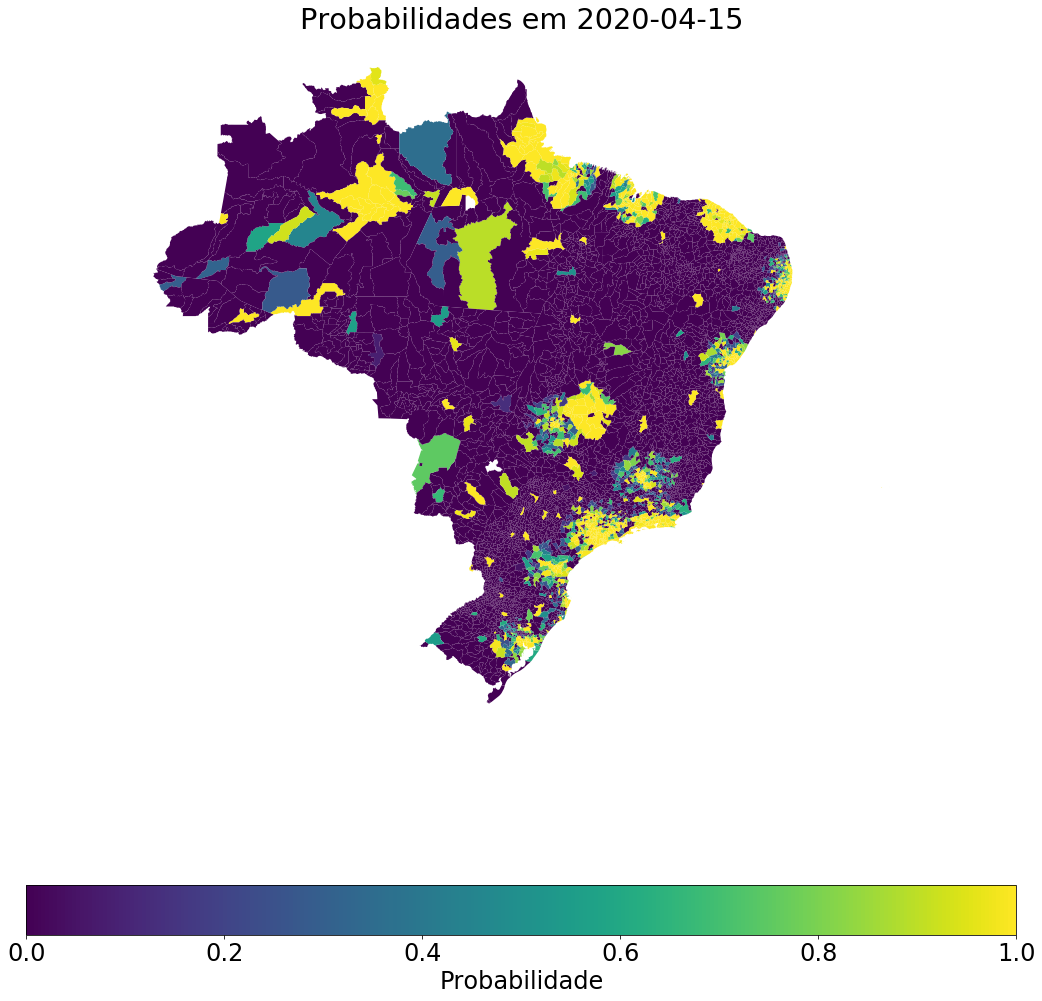

In [76]:
for i,D in enumerate(casesw.columns):
    if mapa_serie['p_'+str(D)].max()==0:
        continue
    fig,ax = plt.subplots(1,1, figsize=(15,15), constrained_layout=False)
    mapa_serie.plot(ax=ax,column='p_'+str(D), legend=True,
                    legend_kwds={'label': "Probabilidade",'orientation': "horizontal"})
    ax.set_title(f'Probabilidades em {D}')
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(f'anim/prob_{i}.png', dpi=200)